This notebook contains BDT variable distribution for leading and subleading leptonJets in control region.

In [1]:
from coffea import hist
from coffea.analysis_objects import JaggedCandidateArray
from coffea.processor import defaultdict_accumulator
import coffea.processor as processor
import uproot

import numpy as np
import matplotlib.pyplot as plt
from FireHydrant.Tools.uproothelpers import NestNestObjArrayToJagged
from FireHydrant.Tools.metfilter import MetFilters

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import json

########## backgrounds ##########
bkgdatasets_=json.load(open('../../MC/Samples/backgrounds_nonempty.json'))
bkgscales_=json.load(open('../../MC/Samples/backgrounds_scale.json'))

# flatten datasets
bkgdatasets = {}
for group in bkgdatasets_:
    for tag in bkgdatasets_[group]:
        files = bkgdatasets_[group][tag]
        bkgdatasets[tag] = {'files': files, 'treename': 'ffNtuples/ffNtuple'}
        if tag=='TTJets': bkgdatasets[tag]['treename'] = 'ffNtuplizer/ffNtuple'

# flatten scales
bkgscales = {}
for group in bkgscales_:
    for tag in bkgscales_[group]:
        bkgscales[tag] = bkgscales_[group][tag]

lumi = 60.432*1e3
for k in bkgscales:
    bkgscales[k] *= lumi

# mapping
bkgmapping = {}
for k in bkgdatasets_: bkgmapping[k] = list(bkgdatasets_[k])
####################################

########## data ##########
datadatasets_=json.load(open('../Samples/control_data2018.json'))
datadatasets = dict(
    A={'files': datadatasets_['A'], 'treename': 'ffNtuplizer/ffNtuple'},
    B={'files': datadatasets_['B'], 'treename': 'ffNtuples/ffNtuple'},
    C={'files': datadatasets_['C'], 'treename': 'ffNtuples/ffNtuple'},
    D={'files': datadatasets_['D'], 'treename': 'ffNtuples/ffNtuple'},
)
datamapping = {'data': list('ABCD')}
####################################

########## combine together ##########
datasets = {}
datasets.update(bkgdatasets)
datasets.update(datadatasets)

mapping = {}
mapping.update(bkgmapping)
mapping.update(datamapping)
####################################

In [3]:
# using regular expressions on dataset name to select just the data
# another method would be to fill a separate data histogram
import re
notdata = re.compile('(?!data)')

## Variables as input for BDT
- leptonJet pT, eta
- neutral energy fraction
- maxd0, mind0
- tkiso, pfiso
- spreadpt, spreaddr
- lambda, epsilon
- ecf 1,2,3

and
- BDT score

In [4]:
class LeptonJetsProcessor(processor.ProcessorABC):
    def __init__(self):
        dataset_axis = hist.Cat('dataset', 'Control region')
        pt_axis       = hist.Bin("pt", "pT [GeV]", 50, 0, 800)
        eta_axis      = hist.Bin("eta", 'eta', 50, -2.4, 2.4)
        nef_axis      = hist.Bin("nef", "neutral energy fraction", 50, 0, 1)
        maxd0_axis    = hist.Bin("maxd0", 'track max |d0|', 50, 0, 0.5)
        mind0_axis    = hist.Bin("mind0", 'track min |d0|', 50, 0, 0.5)
        tkiso_axis    = hist.Bin('tkiso', 'track isolation', 50, 0, 1)
        pfiso_axis    = hist.Bin("pfiso", "PFCands isolation", 50, 0, 1)
        spreadpt_axis = hist.Bin("spreadpt", "spreadpt", 50, 0, 1)
        spreaddr_axis = hist.Bin("spreaddr", "spreaddr", 50, 0, 0.1)
        lambda_axis   = hist.Bin('lamb', 'jet sub - lambda', 50, -8, 0)
        epsilon_axis  = hist.Bin('epsi', 'jet sub - epsilon', 50, 0, 0.25)
        ecfe1_axis    = hist.Bin('ecfe1', 'energy correlation function - e1', 50, 0, 200)
        ecfe2_axis    = hist.Bin('ecfe2', 'energy correlation function - e2', 50, 0, 500)
        ecfe3_axis    = hist.Bin('ecfe3', 'energy correlation function - e3', 50, 0, 300)
        mva_axis      = hist.Bin('mva', 'BDT value', 50, -10, 10)
        
        self._accumulator = processor.dict_accumulator({
            'lead_pt': hist.Hist("#counts/16GeV", dataset_axis, pt_axis),
            "lead_eta": hist.Hist("#counts/0.096", dataset_axis, eta_axis),
            "lead_nef": hist.Hist("#counts/0.02", dataset_axis, nef_axis),
            "lead_maxd0": hist.Hist("#counts/0.01cm", dataset_axis, maxd0_axis),
            "lead_mind0": hist.Hist("#counts/0.01cm", dataset_axis, mind0_axis),
            "lead_tkiso": hist.Hist("#counts/0.02", dataset_axis, tkiso_axis),
            "lead_pfiso": hist.Hist("#counts/0.02", dataset_axis, pfiso_axis),
            "lead_spreadpt": hist.Hist("#counts/0.02", dataset_axis, spreadpt_axis),
            "lead_spreaddr": hist.Hist("#counts/0.002", dataset_axis, spreaddr_axis),
            "lead_lamb": hist.Hist("#counts/0.16", dataset_axis, lambda_axis),
            "lead_epsi": hist.Hist("#counts/0.005", dataset_axis, epsilon_axis),
            "lead_ecfe1": hist.Hist("#counts/4", dataset_axis, ecfe1_axis),
            "lead_ecfe2": hist.Hist("#counts/10", dataset_axis, ecfe2_axis),
            "lead_ecfe3": hist.Hist("#counts/6", dataset_axis, ecfe3_axis),
            "lead_mva": hist.Hist("#counts/0.4", dataset_axis, mva_axis),
            
            'subl_pt': hist.Hist("#counts/16GeV", dataset_axis, pt_axis),
            "subl_eta": hist.Hist("#counts/0.096", dataset_axis, eta_axis),
            "subl_nef": hist.Hist("#counts/0.02", dataset_axis, nef_axis),
            "subl_maxd0": hist.Hist("#counts/0.01cm", dataset_axis, maxd0_axis),
            "subl_mind0": hist.Hist("#counts/0.01cm", dataset_axis, mind0_axis),
            "subl_tkiso": hist.Hist("#counts/0.02", dataset_axis, tkiso_axis),
            "subl_pfiso": hist.Hist("#counts/0.02", dataset_axis, pfiso_axis),
            "subl_spreadpt": hist.Hist("#counts/0.02", dataset_axis, spreadpt_axis),
            "subl_spreaddr": hist.Hist("#counts/0.002", dataset_axis, spreaddr_axis),
            "subl_lamb": hist.Hist("#counts/0.16", dataset_axis, lambda_axis),
            "subl_epsi": hist.Hist("#counts/0.005", dataset_axis, epsilon_axis),
            "subl_ecfe1": hist.Hist("#counts/4", dataset_axis, ecfe1_axis),
            "subl_ecfe2": hist.Hist("#counts/10", dataset_axis, ecfe2_axis),
            "subl_ecfe3": hist.Hist("#counts/6", dataset_axis, ecfe3_axis),
            "subl_mva": hist.Hist("#counts/0.4", dataset_axis, mva_axis),
        })

    @property
    def accumulator(self):
        return self._accumulator
    
    def process(self, df):
        output = self.accumulator.identity()
        
        dataset = df['dataset']
        
        maxd0_ = np.abs(NestNestObjArrayToJagged(df['pfjet_pfcand_tkD0'])).fillna(0).max()
        mind0_ = np.abs(NestNestObjArrayToJagged(df['pfjet_pfcand_tkD0'])).fillna(0).min()
        
        leptonjets = JaggedCandidateArray.candidatesfromcounts(
            df['pfjet_p4'],
            px=df['pfjet_p4.fCoordinates.fX'],
            py=df['pfjet_p4.fCoordinates.fY'],
            pz=df['pfjet_p4.fCoordinates.fZ'],
            energy=df['pfjet_p4.fCoordinates.fT'],
            nef=(df['pfjet_neutralEmE']+df['pfjet_neutralHadronE'])/df['pfjet_p4.fCoordinates.fT'],
            maxd0=maxd0_.content,
            mind0=mind0_.content,
            tkiso=df['pfjet_tkIsolation05'],
            pfiso=df['pfjet_pfIsolation05'],
            spreadpt=df['pfjet_ptDistribution'],
            spreaddr=df['pfjet_dRSpread'],
            lamb=df['pfjet_subjet_lambda'],
            epsi=df['pfjet_subjet_epsilon'],
            ecf1=df['pfjet_subjet_ecf1'],
            ecf2=df['pfjet_subjet_ecf2'],
            ecf3=df['pfjet_subjet_ecf3'],
            mva=df['pfjet_mva'],
        )
        ## apply MET filters ##
        metfiltermask = np.logical_or.reduce([df[mf] for mf in MetFilters])
        leptonjets = leptonjets[metfiltermask]
        
        twoleptonjets = leptonjets.counts>=2
        dileptonjets = leptonjets[twoleptonjets]
        leptonjetpair = dileptonjets.distincts()
        sumpt = leptonjetpair.i0.pt+leptonjetpair.i1.pt
        if sumpt.size!=0:
            leadingLjPair = leptonjetpair[sumpt.argmax()]
            controlregion = np.abs(leadingLjPair.i0.p4.delta_phi(leadingLjPair.i1.p4))<2.5
            leadingLjPair = leadingLjPair[controlregion]
            _comp = leadingLjPair.i0.pt<leadingLjPair.i1.pt
            leadlj = leadingLjPair.i0*(~_comp)+leadingLjPair.i1*(_comp)
            subllj = leadingLjPair.i0*(_comp)+leadingLjPair.i1*(~_comp)

            output['lead_pt']      .fill(dataset=dataset, pt=leadlj.p4.pt.flatten())
            output['lead_eta']     .fill(dataset=dataset, eta=leadlj.p4.eta.flatten())
            output['lead_nef']     .fill(dataset=dataset, nef=leadlj.nef.flatten())
            output['lead_maxd0']   .fill(dataset=dataset, maxd0=leadlj.maxd0.flatten())
            output['lead_mind0']   .fill(dataset=dataset, mind0=leadlj.mind0.flatten())
            output['lead_tkiso']   .fill(dataset=dataset, tkiso=leadlj.tkiso.flatten())
            output['lead_pfiso']   .fill(dataset=dataset, pfiso=leadlj.pfiso.flatten())
            output['lead_spreadpt'].fill(dataset=dataset, spreadpt=leadlj.spreadpt.flatten())
            output['lead_spreaddr'].fill(dataset=dataset, spreaddr=leadlj.spreaddr.flatten())
            output['lead_lamb']    .fill(dataset=dataset, lamb=leadlj.lamb.flatten())
            output['lead_epsi']    .fill(dataset=dataset, epsi=leadlj.epsi.flatten())
            output['lead_ecfe1']   .fill(dataset=dataset, ecfe1=leadlj.ecf1.flatten())
            output['lead_ecfe2']   .fill(dataset=dataset, ecfe2=leadlj.ecf2.flatten())
            output['lead_ecfe3']   .fill(dataset=dataset, ecfe3=leadlj.ecf3.flatten())
            output['lead_mva']     .fill(dataset=dataset, mva=leadlj.mva.flatten())
            
            output['subl_pt']      .fill(dataset=dataset, pt=subllj.p4.pt.flatten())
            output['subl_eta']     .fill(dataset=dataset, eta=subllj.p4.eta.flatten())
            output['subl_nef']     .fill(dataset=dataset, nef=subllj.nef.flatten())
            output['subl_maxd0']   .fill(dataset=dataset, maxd0=subllj.maxd0.flatten())
            output['subl_mind0']   .fill(dataset=dataset, mind0=subllj.mind0.flatten())
            output['subl_tkiso']   .fill(dataset=dataset, tkiso=subllj.tkiso.flatten())
            output['subl_pfiso']   .fill(dataset=dataset, pfiso=subllj.pfiso.flatten())
            output['subl_spreadpt'].fill(dataset=dataset, spreadpt=subllj.spreadpt.flatten())
            output['subl_spreaddr'].fill(dataset=dataset, spreaddr=subllj.spreaddr.flatten())
            output['subl_lamb']    .fill(dataset=dataset, lamb=subllj.lamb.flatten())
            output['subl_epsi']    .fill(dataset=dataset, epsi=subllj.epsi.flatten())
            output['subl_ecfe1']   .fill(dataset=dataset, ecfe1=subllj.ecf1.flatten())
            output['subl_ecfe2']   .fill(dataset=dataset, ecfe2=subllj.ecf2.flatten())
            output['subl_ecfe3']   .fill(dataset=dataset, ecfe3=subllj.ecf3.flatten())
            output['subl_mva']     .fill(dataset=dataset, mva=subllj.mva.flatten())
        
        return output
    
    def postprocess(self, accumulator):
        origidentity = list(accumulator)
        
        for k in origidentity:
            # scale
            accumulator[k].scale(bkgscales, axis='dataset')
            # cat grouping
            accumulator[k+'_cat'] = accumulator[k].group(hist.Cat("cat", "datasets"), "dataset", mapping)
        
        return accumulator

In [5]:
output = processor.run_uproot_job(datasets,
                                  treename=None,
                                  processor_instance=LeptonJetsProcessor(),
                                  executor=processor.futures_executor,
                                  executor_args=dict(workers=12, flatten=True),
                                  chunksize=500000,
                                 )

Processing: 100%|██████████| 5366/5366 [06:33<00:00, 13.63items/s]


In [6]:
fill_opts = {
    'edgecolor': (0,0,0,0.3),
    'alpha': 0.8
}
error_opts = {
    'label':'Stat. Unc.',
    'hatch':'xxx',
    'facecolor':'none',
    'edgecolor':(0,0,0,.5),
    'linewidth': 0
}
data_err_opts = {
    'linestyle':'none',
    'marker': '.',
    'markersize': 10.,
    'color':'k',
    'elinewidth': 1,
    'emarker': '_'
}

/uscms/home/wsi/nobackup/miniconda3/envs/FireHydrant/lib/python3.7/site-packages/coffea/hist/plot.py:313: RuntimeWarning: invalid value encountered in true_divide
  rsumw = sumw_num / sumw_denom
/uscms/home/wsi/nobackup/miniconda3/envs/FireHydrant/lib/python3.7/site-packages/coffea/hist/plot.py:320: RuntimeWarning: invalid value encountered in true_divide
  rsumw_err = np.abs(poisson_interval(rsumw, sumw2_num / sumw_denom**2) - rsumw)
/uscms/home/wsi/nobackup/miniconda3/envs/FireHydrant/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:871: RuntimeWarning: invalid value encountered in greater
  cond = logical_and(cond, (asarray(arg) > 0))
/uscms/home/wsi/nobackup/miniconda3/envs/FireHydrant/lib/python3.7/site-packages/coffea/hist/plot.py:334: RuntimeWarning: invalid value encountered in true_divide
  denom_unc = poisson_interval(unity, sumw2_denom / sumw_denom**2)


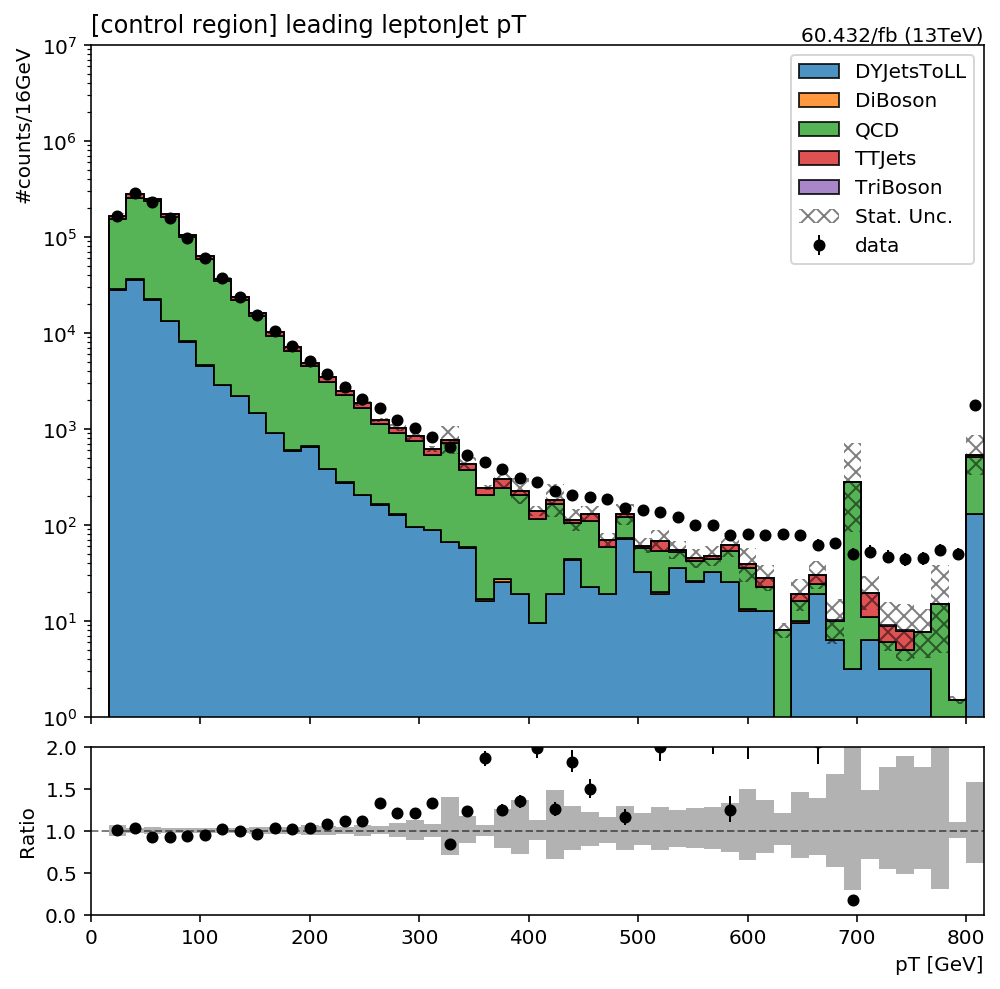

In [7]:
fig, (ax, rax) = plt.subplots(2, 1, figsize=(8,8), gridspec_kw={"height_ratios": (4, 1)}, sharex=True)
fig.subplots_adjust(hspace=.07)

hist.plot1d(output['lead_pt_cat'][notdata], overlay='cat', ax=ax,
           clear=False, stack=True, overflow='over',
           line_opts=None, fill_opts=fill_opts, error_opts=error_opts)
hist.plot1d(output['lead_pt_cat']['data'], overlay='cat', ax=ax,
           overflow='over', clear=False,
           error_opts=data_err_opts)
ax.autoscale(axis='x', tight=True)
ax.set_yscale('log')
ax.set_ylim([1, 1e7])
ax.set_xlabel(None)
leg=ax.legend()

hist.plotratio(output['lead_pt_cat']['data'].sum('cat'), output['lead_pt_cat'][notdata].sum('cat'),
              ax=rax, overflow='over', unc='num',
              error_opts=data_err_opts, denom_fill_opts={}, guide_opts={})
rax.set_ylabel('Ratio')
rax.set_ylim(0,2)

rax.set_xlabel(rax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")
ax.set_title('[control region] leading leptonJet pT', x=0.0, ha="left")
ax.text(1,1,'60.432/fb (13TeV)', ha='right', va='bottom', transform=ax.transAxes);

/uscms/home/wsi/nobackup/miniconda3/envs/FireHydrant/lib/python3.7/site-packages/coffea/hist/plot.py:313: RuntimeWarning: divide by zero encountered in true_divide
  rsumw = sumw_num / sumw_denom
/uscms/home/wsi/nobackup/miniconda3/envs/FireHydrant/lib/python3.7/site-packages/coffea/hist/plot.py:320: RuntimeWarning: divide by zero encountered in true_divide
  rsumw_err = np.abs(poisson_interval(rsumw, sumw2_num / sumw_denom**2) - rsumw)
/uscms/home/wsi/nobackup/miniconda3/envs/FireHydrant/lib/python3.7/site-packages/coffea/hist/plot.py:33: RuntimeWarning: invalid value encountered in true_divide
  scale[sumw != 0] = sumw2[sumw != 0] / sumw[sumw != 0]


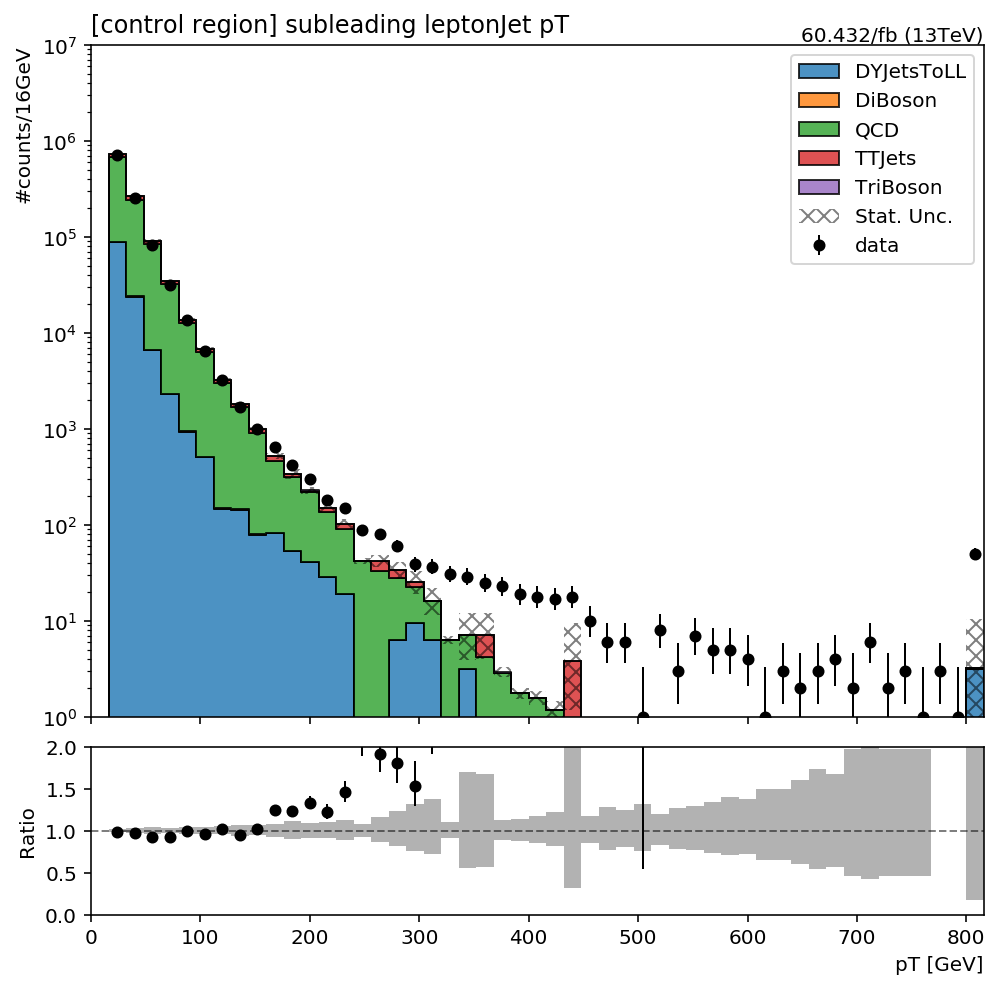

In [8]:
fig, (ax, rax) = plt.subplots(2, 1, figsize=(8,8), gridspec_kw={"height_ratios": (4, 1)}, sharex=True)
fig.subplots_adjust(hspace=.07)

hist.plot1d(output['subl_pt_cat'][notdata], overlay='cat', ax=ax,
           clear=False, stack=True, overflow='over',
           line_opts=None, fill_opts=fill_opts, error_opts=error_opts)
hist.plot1d(output['subl_pt_cat']['data'], overlay='cat', ax=ax,
           overflow='over', clear=False,
           error_opts=data_err_opts)
ax.autoscale(axis='x', tight=True)
ax.set_yscale('log')
ax.set_ylim([1, 1e7])
ax.set_xlabel(None)
leg=ax.legend()

hist.plotratio(output['subl_pt_cat']['data'].sum('cat'), output['subl_pt_cat'][notdata].sum('cat'),
              ax=rax, overflow='over', unc='num',
              error_opts=data_err_opts, denom_fill_opts={}, guide_opts={})
rax.set_ylabel('Ratio')
rax.set_ylim(0,2)

rax.set_xlabel(rax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")
ax.set_title('[control region] subleading leptonJet pT', x=0.0, ha="left")
ax.text(1,1,'60.432/fb (13TeV)', ha='right', va='bottom', transform=ax.transAxes);

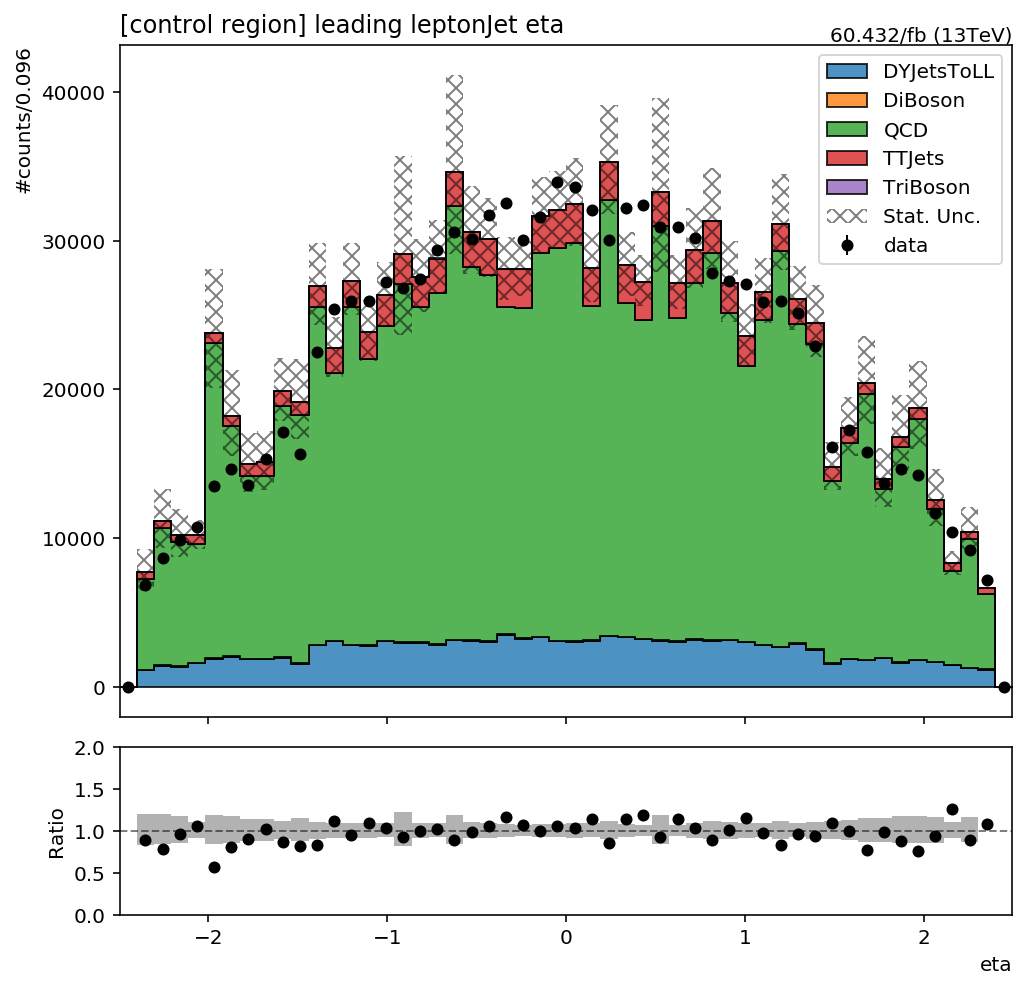

In [9]:
fig, (ax, rax) = plt.subplots(2, 1, figsize=(8,8), gridspec_kw={"height_ratios": (4, 1)}, sharex=True)
fig.subplots_adjust(hspace=.07)

hist.plot1d(output['lead_eta_cat'][notdata], overlay='cat', ax=ax,
           clear=False, stack=True, overflow='all',
           line_opts=None, fill_opts=fill_opts, error_opts=error_opts)
hist.plot1d(output['lead_eta_cat']['data'], overlay='cat', ax=ax,
           overflow='all', clear=False,
           error_opts=data_err_opts)
ax.autoscale(axis='x', tight=True)

ax.set_xlabel(None)
leg=ax.legend()

hist.plotratio(output['lead_eta_cat']['data'].sum('cat'), output['lead_eta_cat'][notdata].sum('cat'),
              ax=rax, overflow='all', unc='num',
              error_opts=data_err_opts, denom_fill_opts={}, guide_opts={})
rax.set_ylabel('Ratio')
rax.set_ylim(0,2)

rax.set_xlabel(rax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")
ax.set_title('[control region] leading leptonJet eta', x=0.0, ha="left")
ax.text(1,1,'60.432/fb (13TeV)', ha='right', va='bottom', transform=ax.transAxes);

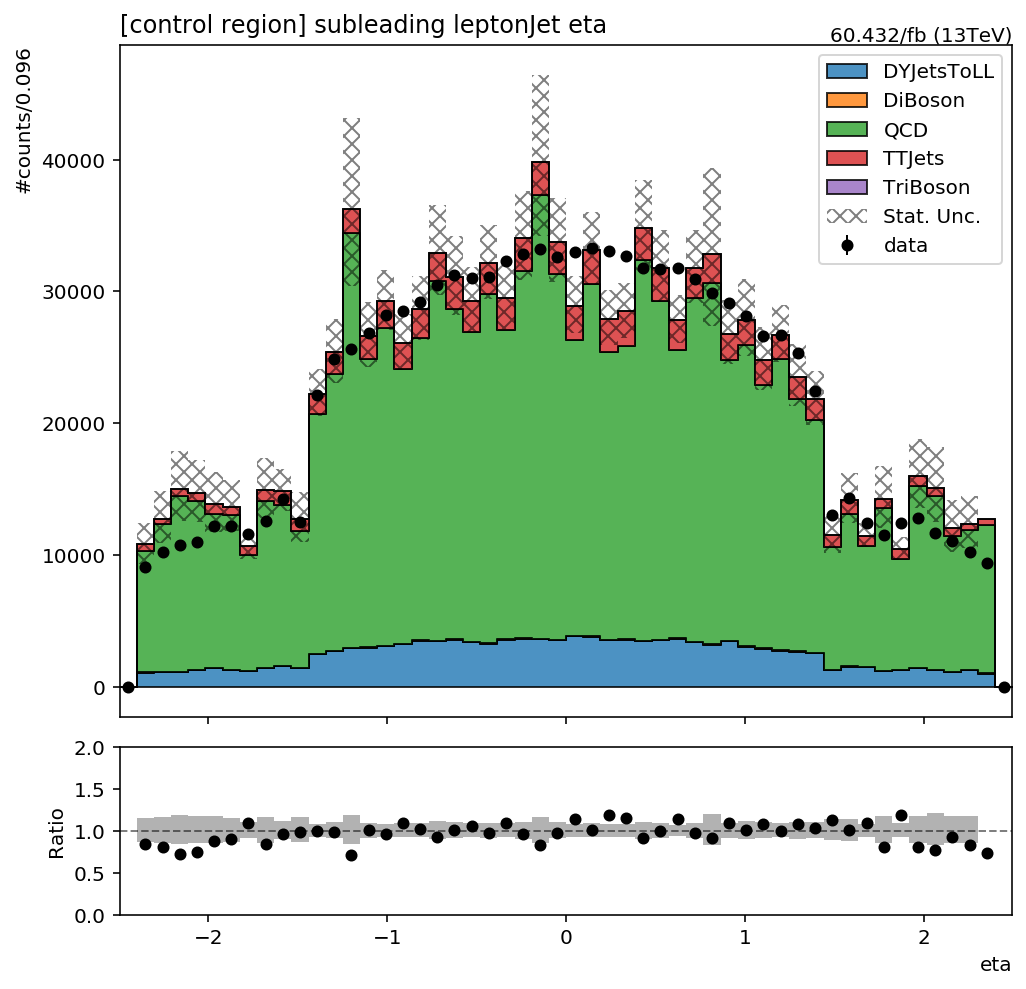

In [10]:
fig, (ax, rax) = plt.subplots(2, 1, figsize=(8,8), gridspec_kw={"height_ratios": (4, 1)}, sharex=True)
fig.subplots_adjust(hspace=.07)

hist.plot1d(output['subl_eta_cat'][notdata], overlay='cat', ax=ax,
           clear=False, stack=True, overflow='all',
           line_opts=None, fill_opts=fill_opts, error_opts=error_opts)
hist.plot1d(output['subl_eta_cat']['data'], overlay='cat', ax=ax,
           overflow='all', clear=False,
           error_opts=data_err_opts)
ax.autoscale(axis='x', tight=True)

ax.set_xlabel(None)
leg=ax.legend()

hist.plotratio(output['subl_eta_cat']['data'].sum('cat'), output['subl_eta_cat'][notdata].sum('cat'),
              ax=rax, overflow='all', unc='num',
              error_opts=data_err_opts, denom_fill_opts={}, guide_opts={})
rax.set_ylabel('Ratio')
rax.set_ylim(0,2)

rax.set_xlabel(rax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")
ax.set_title('[control region] subleading leptonJet eta', x=0.0, ha="left")
ax.text(1,1,'60.432/fb (13TeV)', ha='right', va='bottom', transform=ax.transAxes);

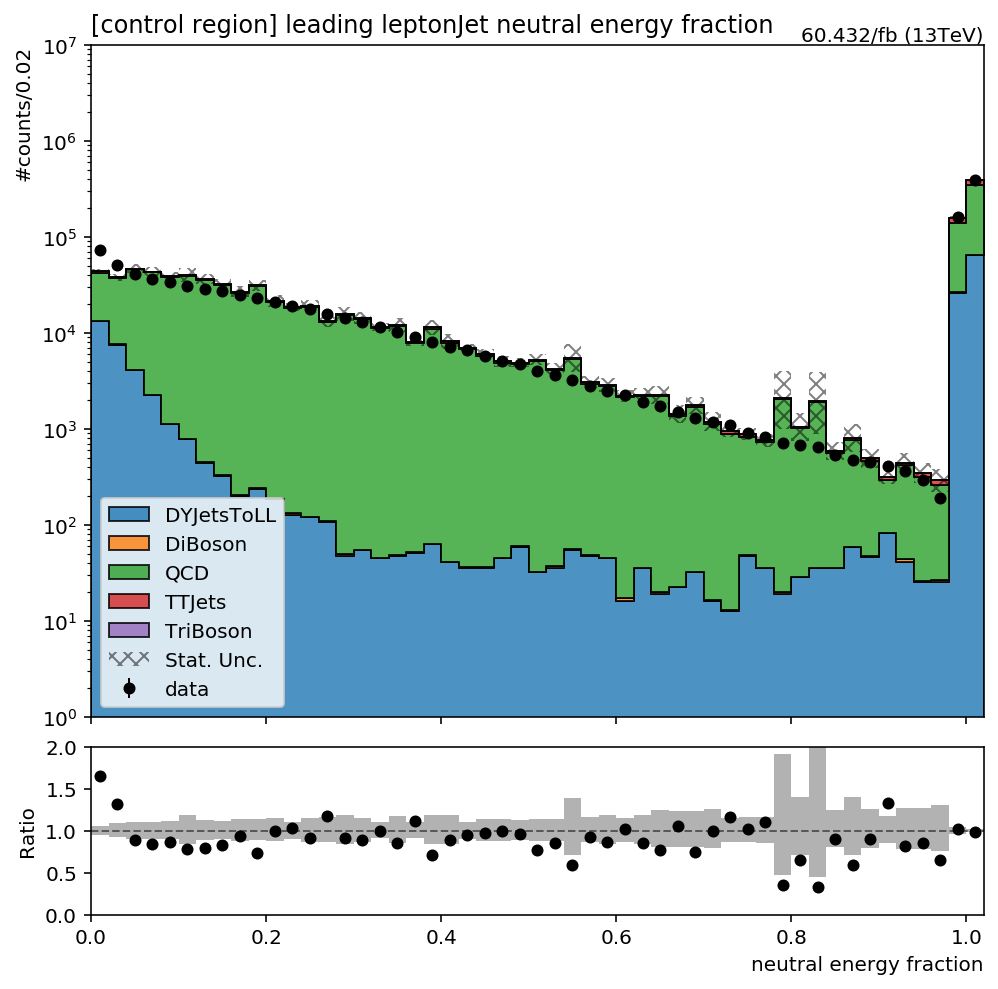

In [11]:
fig, (ax, rax) = plt.subplots(2, 1, figsize=(8,8), gridspec_kw={"height_ratios": (4, 1)}, sharex=True)
fig.subplots_adjust(hspace=.07)

hist.plot1d(output['lead_nef_cat'][notdata], overlay='cat', ax=ax,
           clear=False, stack=True, overflow='over',
           line_opts=None, fill_opts=fill_opts, error_opts=error_opts)
hist.plot1d(output['lead_nef_cat']['data'], overlay='cat', ax=ax,
           overflow='over', clear=False,
           error_opts=data_err_opts)
ax.autoscale(axis='x', tight=True)
ax.set_yscale('log')
ax.set_ylim([1, 1e7])
ax.set_xlabel(None)
leg=ax.legend()

hist.plotratio(output['lead_nef_cat']['data'].sum('cat'), output['lead_nef_cat'][notdata].sum('cat'),
              ax=rax, overflow='over', unc='num',
              error_opts=data_err_opts, denom_fill_opts={}, guide_opts={})
rax.set_ylabel('Ratio')
rax.set_ylim(0,2)

rax.set_xlabel(rax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")
ax.set_title('[control region] leading leptonJet neutral energy fraction', x=0.0, ha="left")
ax.text(1,1,'60.432/fb (13TeV)', ha='right', va='bottom', transform=ax.transAxes);

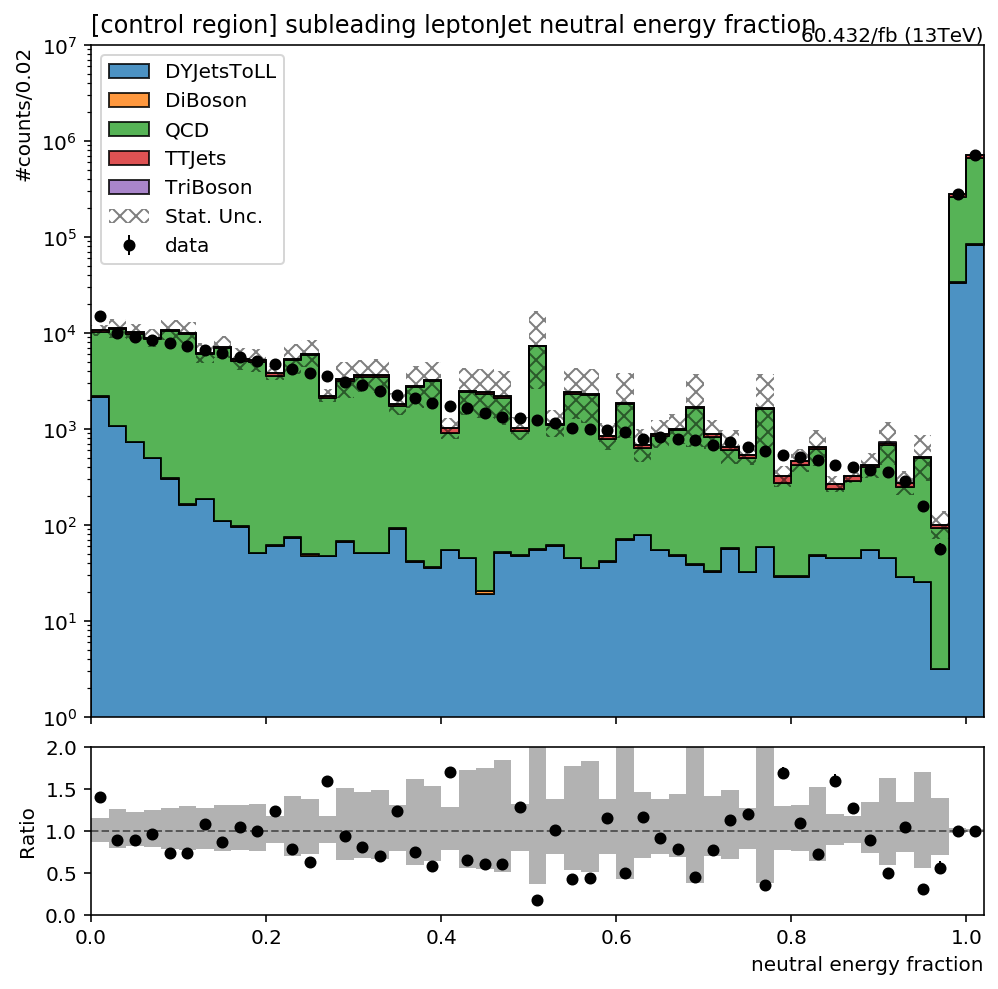

In [12]:
fig, (ax, rax) = plt.subplots(2, 1, figsize=(8,8), gridspec_kw={"height_ratios": (4, 1)}, sharex=True)
fig.subplots_adjust(hspace=.07)

hist.plot1d(output['subl_nef_cat'][notdata], overlay='cat', ax=ax,
           clear=False, stack=True, overflow='over',
           line_opts=None, fill_opts=fill_opts, error_opts=error_opts)
hist.plot1d(output['subl_nef_cat']['data'], overlay='cat', ax=ax,
           overflow='over', clear=False,
           error_opts=data_err_opts)
ax.autoscale(axis='x', tight=True)
ax.set_yscale('log')
ax.set_ylim([1, 1e7])
ax.set_xlabel(None)
leg=ax.legend()

hist.plotratio(output['subl_nef_cat']['data'].sum('cat'), output['subl_nef_cat'][notdata].sum('cat'),
              ax=rax, overflow='over', unc='num',
              error_opts=data_err_opts, denom_fill_opts={}, guide_opts={})
rax.set_ylabel('Ratio')
rax.set_ylim(0,2)

rax.set_xlabel(rax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")
ax.set_title('[control region] subleading leptonJet neutral energy fraction', x=0.0, ha="left")
ax.text(1,1,'60.432/fb (13TeV)', ha='right', va='bottom', transform=ax.transAxes);

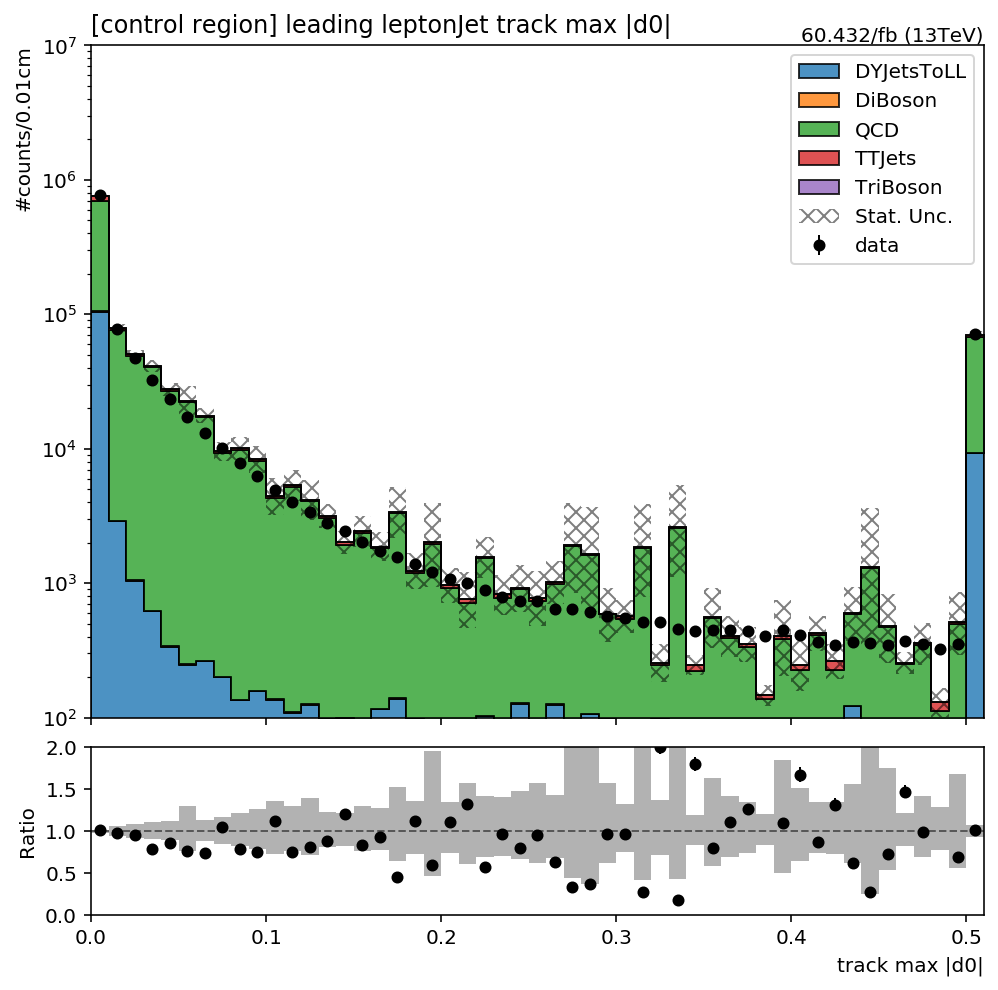

In [13]:
fig, (ax, rax) = plt.subplots(2, 1, figsize=(8,8), gridspec_kw={"height_ratios": (4, 1)}, sharex=True)
fig.subplots_adjust(hspace=.07)

hist.plot1d(output['lead_maxd0_cat'][notdata], overlay='cat', ax=ax,
           clear=False, stack=True, overflow='over',
           line_opts=None, fill_opts=fill_opts, error_opts=error_opts)
hist.plot1d(output['lead_maxd0_cat']['data'], overlay='cat', ax=ax,
           overflow='over', clear=False,
           error_opts=data_err_opts)
ax.autoscale(axis='x', tight=True)
ax.set_yscale('log')
ax.set_ylim([1e2, 1e7])
ax.set_xlabel(None)
leg=ax.legend()

hist.plotratio(output['lead_maxd0_cat']['data'].sum('cat'), output['lead_maxd0_cat'][notdata].sum('cat'),
              ax=rax, overflow='over', unc='num',
              error_opts=data_err_opts, denom_fill_opts={}, guide_opts={})
rax.set_ylabel('Ratio')
rax.set_ylim(0,2)

rax.set_xlabel(rax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")
ax.set_title('[control region] leading leptonJet track max |d0|', x=0.0, ha="left")
ax.text(1,1,'60.432/fb (13TeV)', ha='right', va='bottom', transform=ax.transAxes);

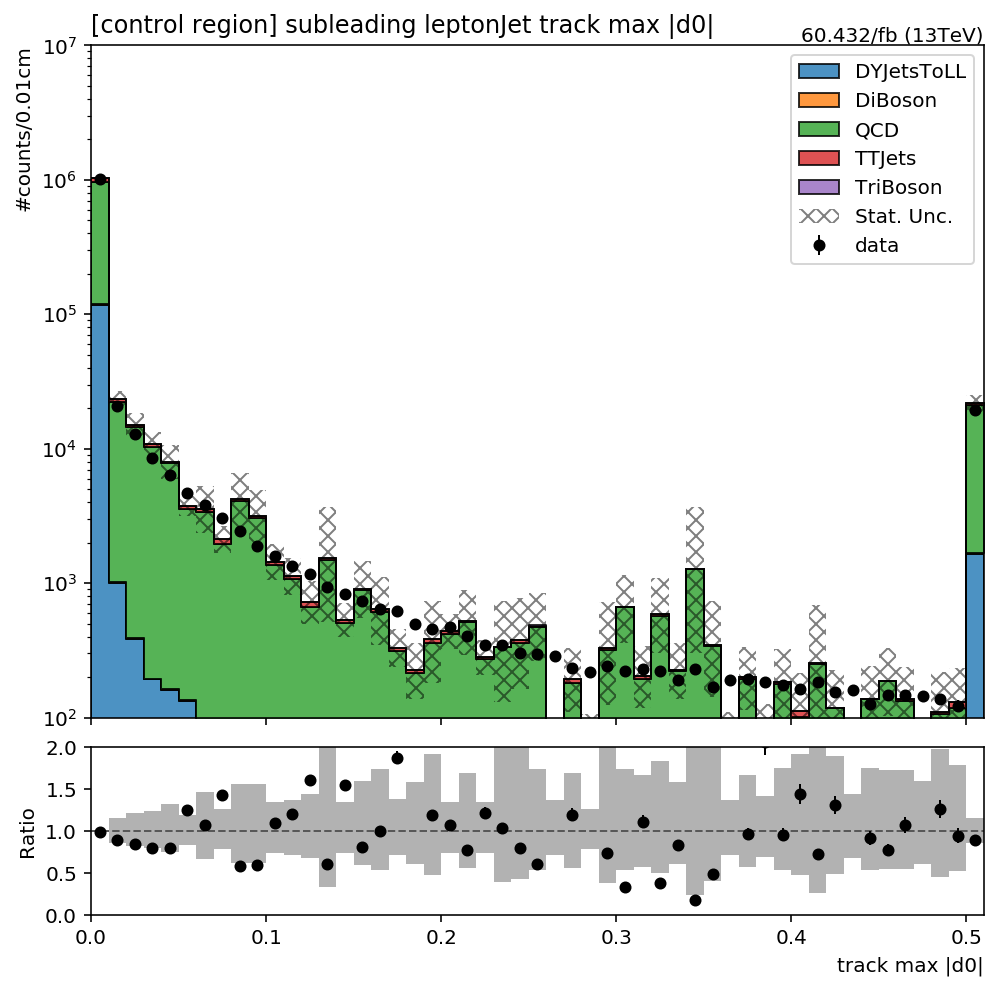

In [14]:
fig, (ax, rax) = plt.subplots(2, 1, figsize=(8,8), gridspec_kw={"height_ratios": (4, 1)}, sharex=True)
fig.subplots_adjust(hspace=.07)

hist.plot1d(output['subl_maxd0_cat'][notdata], overlay='cat', ax=ax,
           clear=False, stack=True, overflow='over',
           line_opts=None, fill_opts=fill_opts, error_opts=error_opts)
hist.plot1d(output['subl_maxd0_cat']['data'], overlay='cat', ax=ax,
           overflow='over', clear=False,
           error_opts=data_err_opts)
ax.autoscale(axis='x', tight=True)
ax.set_yscale('log')
ax.set_ylim([1e2, 1e7])
ax.set_xlabel(None)
leg=ax.legend()

hist.plotratio(output['subl_maxd0_cat']['data'].sum('cat'), output['subl_maxd0_cat'][notdata].sum('cat'),
              ax=rax, overflow='over', unc='num',
              error_opts=data_err_opts, denom_fill_opts={}, guide_opts={})
rax.set_ylabel('Ratio')
rax.set_ylim(0,2)

rax.set_xlabel(rax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")
ax.set_title('[control region] subleading leptonJet track max |d0|', x=0.0, ha="left")
ax.text(1,1,'60.432/fb (13TeV)', ha='right', va='bottom', transform=ax.transAxes);

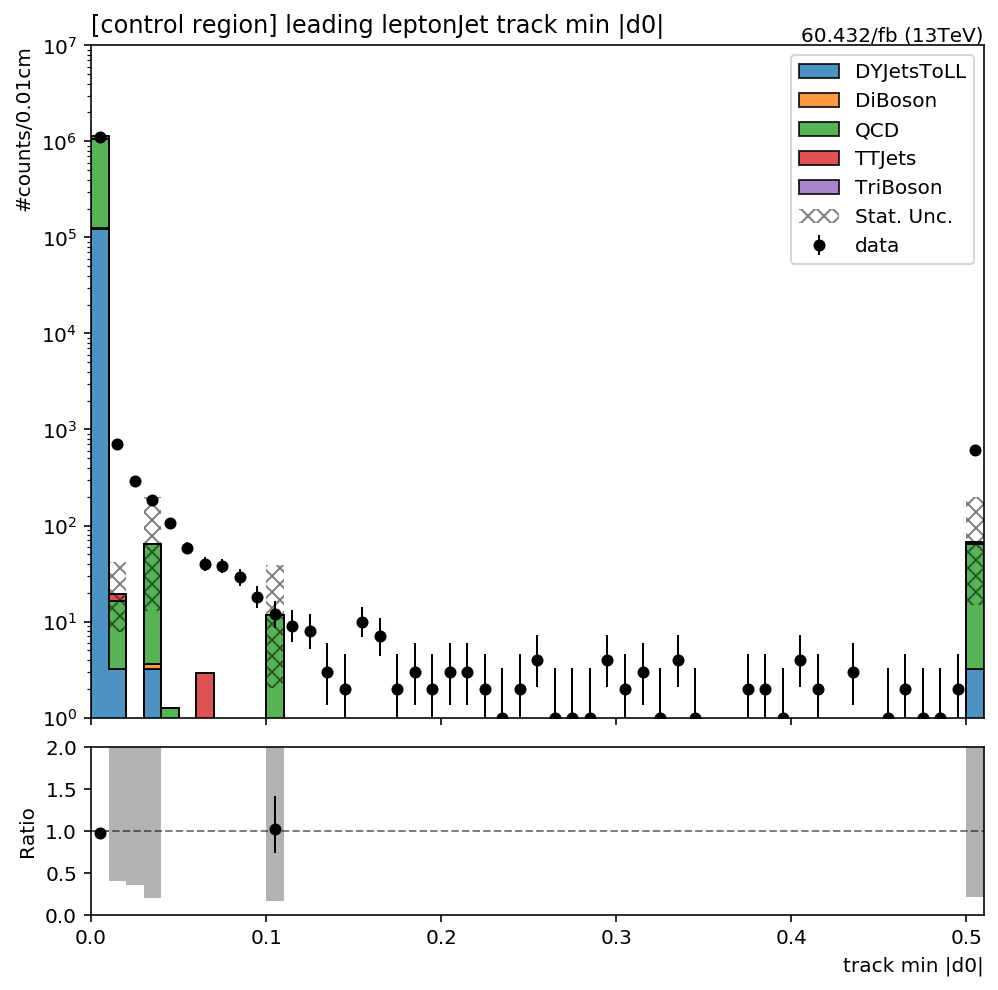

In [15]:
fig, (ax, rax) = plt.subplots(2, 1, figsize=(8,8), gridspec_kw={"height_ratios": (4, 1)}, sharex=True)
fig.subplots_adjust(hspace=.07)

hist.plot1d(output['lead_mind0_cat'][notdata], overlay='cat', ax=ax,
           clear=False, stack=True, overflow='over',
           line_opts=None, fill_opts=fill_opts, error_opts=error_opts)
hist.plot1d(output['lead_mind0_cat']['data'], overlay='cat', ax=ax,
           overflow='over', clear=False,
           error_opts=data_err_opts)
ax.autoscale(axis='x', tight=True)
ax.set_yscale('log')
ax.set_ylim([1, 1e7])
ax.set_xlabel(None)
leg=ax.legend()

hist.plotratio(output['lead_mind0_cat']['data'].sum('cat'), output['lead_mind0_cat'][notdata].sum('cat'),
              ax=rax, overflow='over', unc='num',
              error_opts=data_err_opts, denom_fill_opts={}, guide_opts={})
rax.set_ylabel('Ratio')
rax.set_ylim(0,2)

rax.set_xlabel(rax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")
ax.set_title('[control region] leading leptonJet track min |d0|', x=0.0, ha="left")
ax.text(1,1,'60.432/fb (13TeV)', ha='right', va='bottom', transform=ax.transAxes);

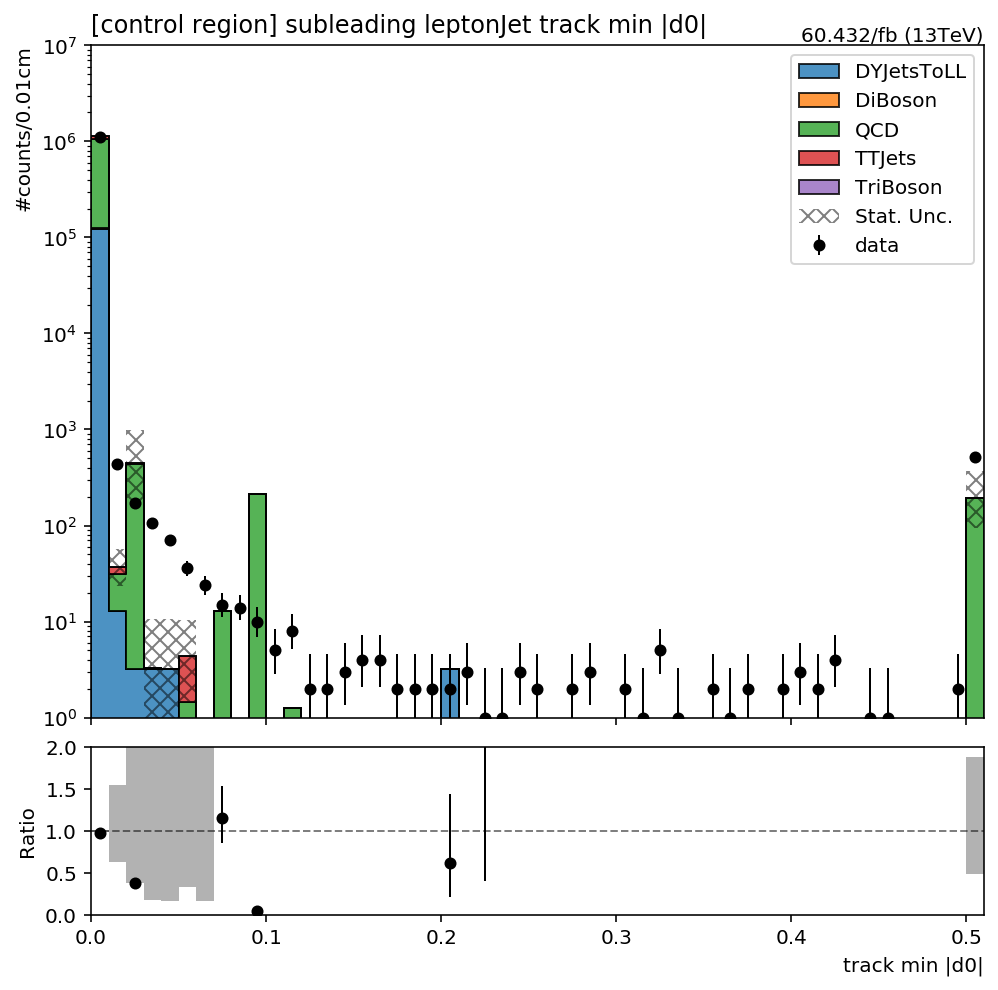

In [16]:
fig, (ax, rax) = plt.subplots(2, 1, figsize=(8,8), gridspec_kw={"height_ratios": (4, 1)}, sharex=True)
fig.subplots_adjust(hspace=.07)

hist.plot1d(output['subl_mind0_cat'][notdata], overlay='cat', ax=ax,
           clear=False, stack=True, overflow='over',
           line_opts=None, fill_opts=fill_opts, error_opts=error_opts)
hist.plot1d(output['subl_mind0_cat']['data'], overlay='cat', ax=ax,
           overflow='over', clear=False,
           error_opts=data_err_opts)
ax.autoscale(axis='x', tight=True)
ax.set_yscale('log')
ax.set_ylim([1, 1e7])
ax.set_xlabel(None)
leg=ax.legend()

hist.plotratio(output['subl_mind0_cat']['data'].sum('cat'), output['subl_mind0_cat'][notdata].sum('cat'),
              ax=rax, overflow='over', unc='num',
              error_opts=data_err_opts, denom_fill_opts={}, guide_opts={})
rax.set_ylabel('Ratio')
rax.set_ylim(0,2)

rax.set_xlabel(rax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")
ax.set_title('[control region] subleading leptonJet track min |d0|', x=0.0, ha="left")
ax.text(1,1,'60.432/fb (13TeV)', ha='right', va='bottom', transform=ax.transAxes);

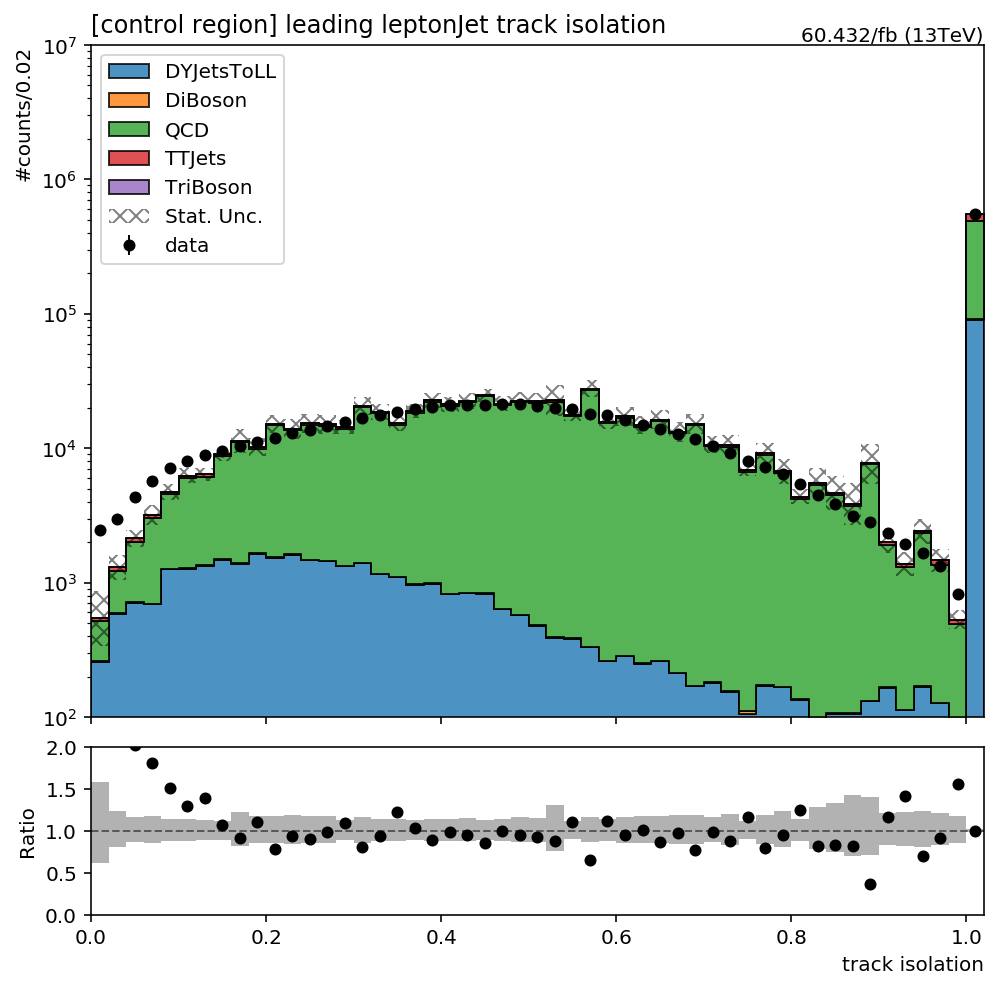

In [17]:
fig, (ax, rax) = plt.subplots(2, 1, figsize=(8,8), gridspec_kw={"height_ratios": (4, 1)}, sharex=True)
fig.subplots_adjust(hspace=.07)

hist.plot1d(output['lead_tkiso_cat'][notdata], overlay='cat', ax=ax,
           clear=False, stack=True, overflow='over',
           line_opts=None, fill_opts=fill_opts, error_opts=error_opts)
hist.plot1d(output['lead_tkiso_cat']['data'], overlay='cat', ax=ax,
           overflow='over', clear=False,
           error_opts=data_err_opts)
ax.autoscale(axis='x', tight=True)
ax.set_yscale('log')
ax.set_ylim([1e2, 1e7])
ax.set_xlabel(None)
leg=ax.legend()

hist.plotratio(output['lead_tkiso_cat']['data'].sum('cat'), output['lead_tkiso_cat'][notdata].sum('cat'),
              ax=rax, overflow='over', unc='num',
              error_opts=data_err_opts, denom_fill_opts={}, guide_opts={})
rax.set_ylabel('Ratio')
rax.set_ylim(0,2)

rax.set_xlabel(rax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")
ax.set_title('[control region] leading leptonJet track isolation', x=0.0, ha="left")
ax.text(1,1,'60.432/fb (13TeV)', ha='right', va='bottom', transform=ax.transAxes);

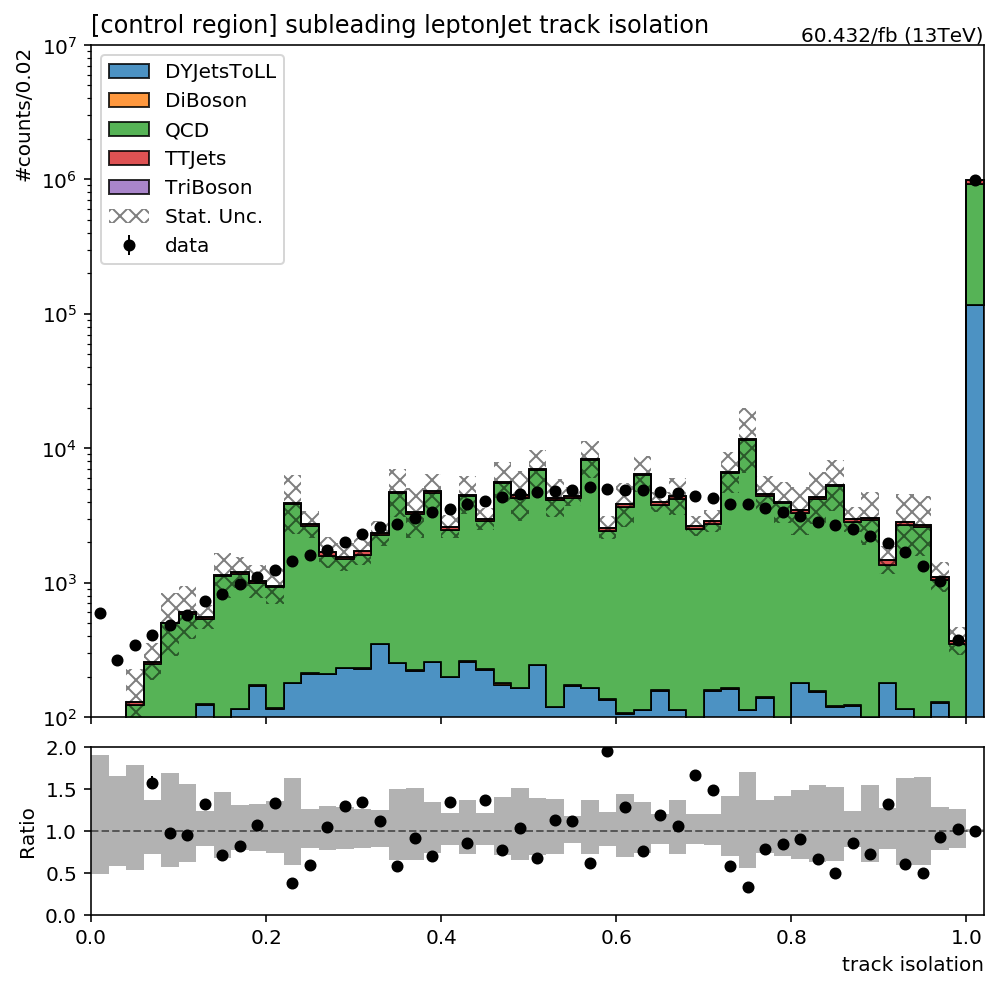

In [18]:
fig, (ax, rax) = plt.subplots(2, 1, figsize=(8,8), gridspec_kw={"height_ratios": (4, 1)}, sharex=True)
fig.subplots_adjust(hspace=.07)

hist.plot1d(output['subl_tkiso_cat'][notdata], overlay='cat', ax=ax,
           clear=False, stack=True, overflow='over',
           line_opts=None, fill_opts=fill_opts, error_opts=error_opts)
hist.plot1d(output['subl_tkiso_cat']['data'], overlay='cat', ax=ax,
           overflow='over', clear=False,
           error_opts=data_err_opts)
ax.autoscale(axis='x', tight=True)
ax.set_yscale('log')
ax.set_ylim([1e2, 1e7])
ax.set_xlabel(None)
leg=ax.legend()

hist.plotratio(output['subl_tkiso_cat']['data'].sum('cat'), output['subl_tkiso_cat'][notdata].sum('cat'),
              ax=rax, overflow='over', unc='num',
              error_opts=data_err_opts, denom_fill_opts={}, guide_opts={})
rax.set_ylabel('Ratio')
rax.set_ylim(0,2)

rax.set_xlabel(rax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")
ax.set_title('[control region] subleading leptonJet track isolation', x=0.0, ha="left")
ax.text(1,1,'60.432/fb (13TeV)', ha='right', va='bottom', transform=ax.transAxes);

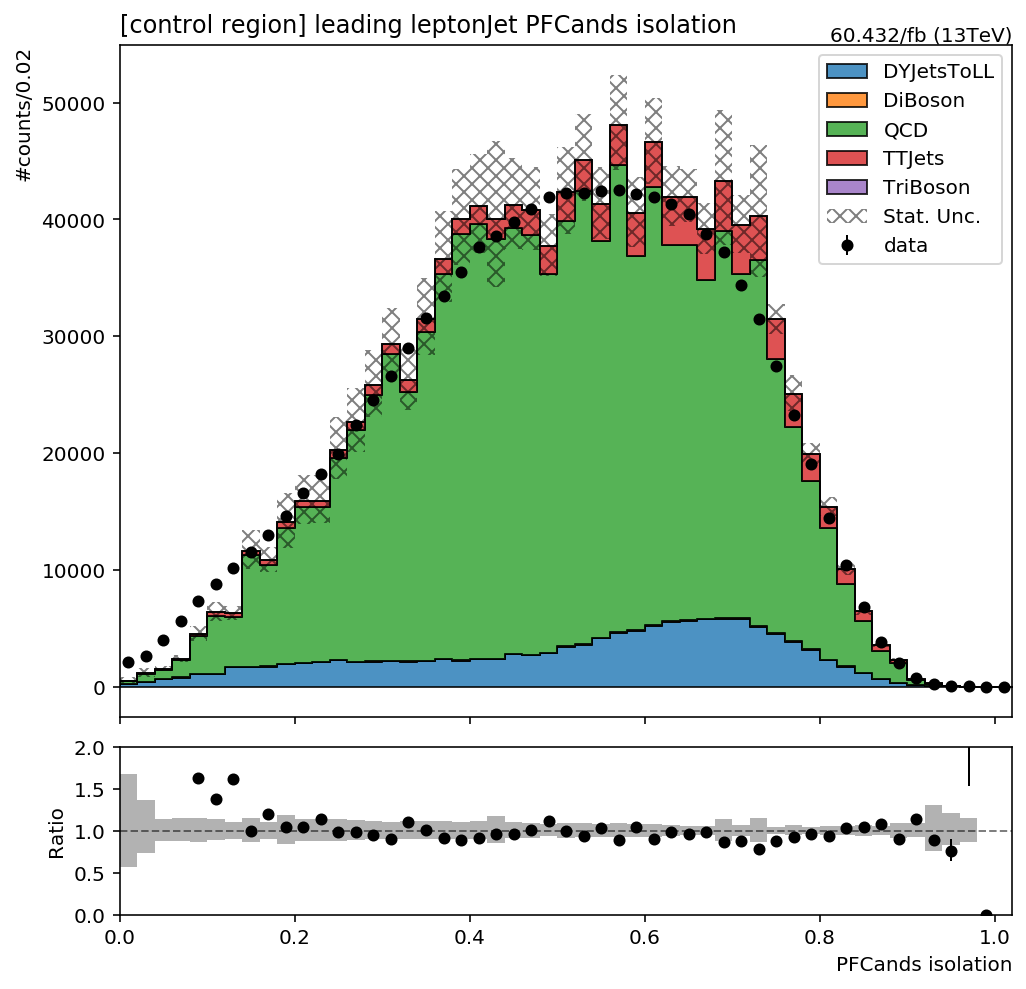

In [19]:
fig, (ax, rax) = plt.subplots(2, 1, figsize=(8,8), gridspec_kw={"height_ratios": (4, 1)}, sharex=True)
fig.subplots_adjust(hspace=.07)

hist.plot1d(output['lead_pfiso_cat'][notdata], overlay='cat', ax=ax,
           clear=False, stack=True, overflow='over',
           line_opts=None, fill_opts=fill_opts, error_opts=error_opts)
hist.plot1d(output['lead_pfiso_cat']['data'], overlay='cat', ax=ax,
           overflow='over', clear=False,
           error_opts=data_err_opts)
ax.autoscale(axis='x', tight=True)

ax.set_xlabel(None)
leg=ax.legend()

hist.plotratio(output['lead_pfiso_cat']['data'].sum('cat'), output['lead_pfiso_cat'][notdata].sum('cat'),
              ax=rax, overflow='over', unc='num',
              error_opts=data_err_opts, denom_fill_opts={}, guide_opts={})
rax.set_ylabel('Ratio')
rax.set_ylim(0,2)

rax.set_xlabel(rax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")
ax.set_title('[control region] leading leptonJet PFCands isolation', x=0.0, ha="left")
ax.text(1,1,'60.432/fb (13TeV)', ha='right', va='bottom', transform=ax.transAxes);

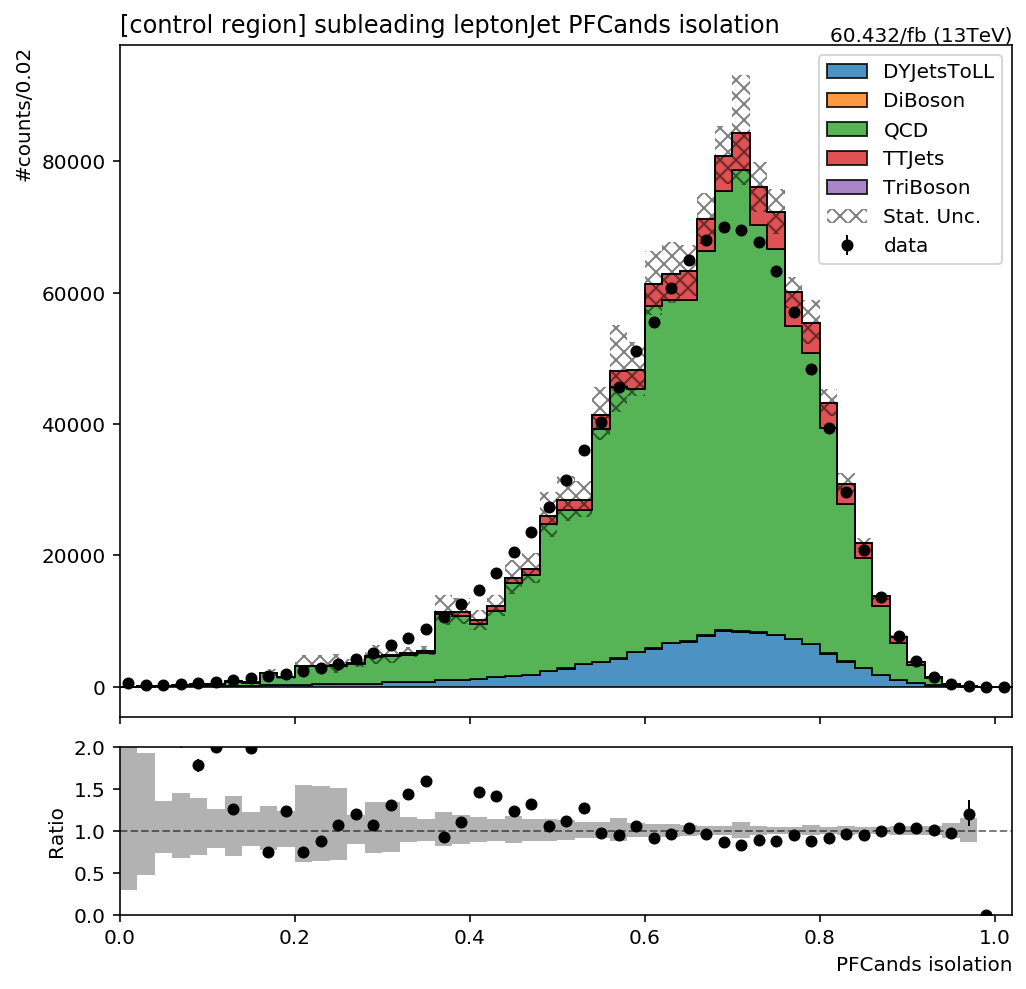

In [20]:
fig, (ax, rax) = plt.subplots(2, 1, figsize=(8,8), gridspec_kw={"height_ratios": (4, 1)}, sharex=True)
fig.subplots_adjust(hspace=.07)

hist.plot1d(output['subl_pfiso_cat'][notdata], overlay='cat', ax=ax,
           clear=False, stack=True, overflow='over',
           line_opts=None, fill_opts=fill_opts, error_opts=error_opts)
hist.plot1d(output['subl_pfiso_cat']['data'], overlay='cat', ax=ax,
           overflow='over', clear=False,
           error_opts=data_err_opts)
ax.autoscale(axis='x', tight=True)

ax.set_xlabel(None)
leg=ax.legend()

hist.plotratio(output['subl_pfiso_cat']['data'].sum('cat'), output['subl_pfiso_cat'][notdata].sum('cat'),
              ax=rax, overflow='over', unc='num',
              error_opts=data_err_opts, denom_fill_opts={}, guide_opts={})
rax.set_ylabel('Ratio')
rax.set_ylim(0,2)

rax.set_xlabel(rax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")
ax.set_title('[control region] subleading leptonJet PFCands isolation', x=0.0, ha="left")
ax.text(1,1,'60.432/fb (13TeV)', ha='right', va='bottom', transform=ax.transAxes);

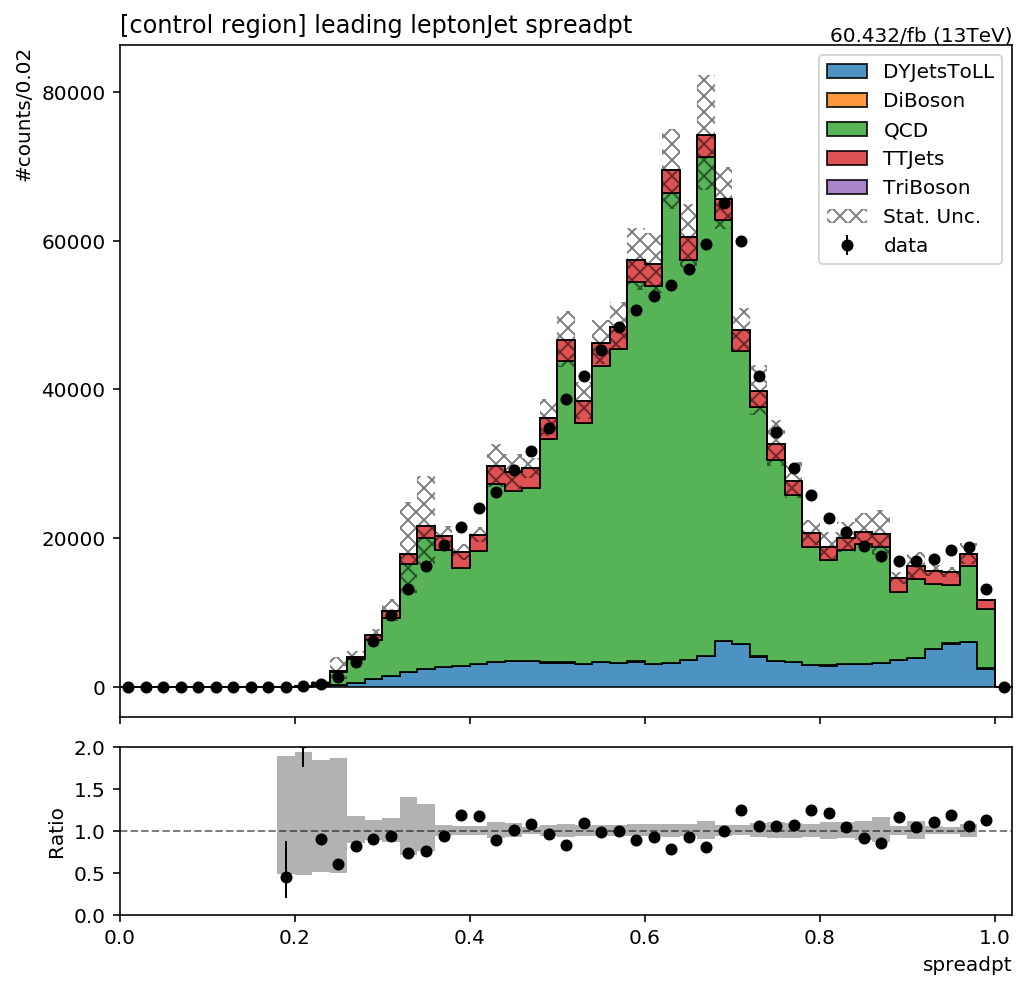

In [21]:
fig, (ax, rax) = plt.subplots(2, 1, figsize=(8,8), gridspec_kw={"height_ratios": (4, 1)}, sharex=True)
fig.subplots_adjust(hspace=.07)

hist.plot1d(output['lead_spreadpt_cat'][notdata], overlay='cat', ax=ax,
           clear=False, stack=True, overflow='over',
           line_opts=None, fill_opts=fill_opts, error_opts=error_opts)
hist.plot1d(output['lead_spreadpt_cat']['data'], overlay='cat', ax=ax,
           overflow='over', clear=False,
           error_opts=data_err_opts)
ax.autoscale(axis='x', tight=True)

ax.set_xlabel(None)
leg=ax.legend()

hist.plotratio(output['lead_spreadpt_cat']['data'].sum('cat'), output['lead_spreadpt_cat'][notdata].sum('cat'),
              ax=rax, overflow='over', unc='num',
              error_opts=data_err_opts, denom_fill_opts={}, guide_opts={})
rax.set_ylabel('Ratio')
rax.set_ylim(0,2)

rax.set_xlabel(rax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")
ax.set_title('[control region] leading leptonJet spreadpt', x=0.0, ha="left")
ax.text(1,1,'60.432/fb (13TeV)', ha='right', va='bottom', transform=ax.transAxes);

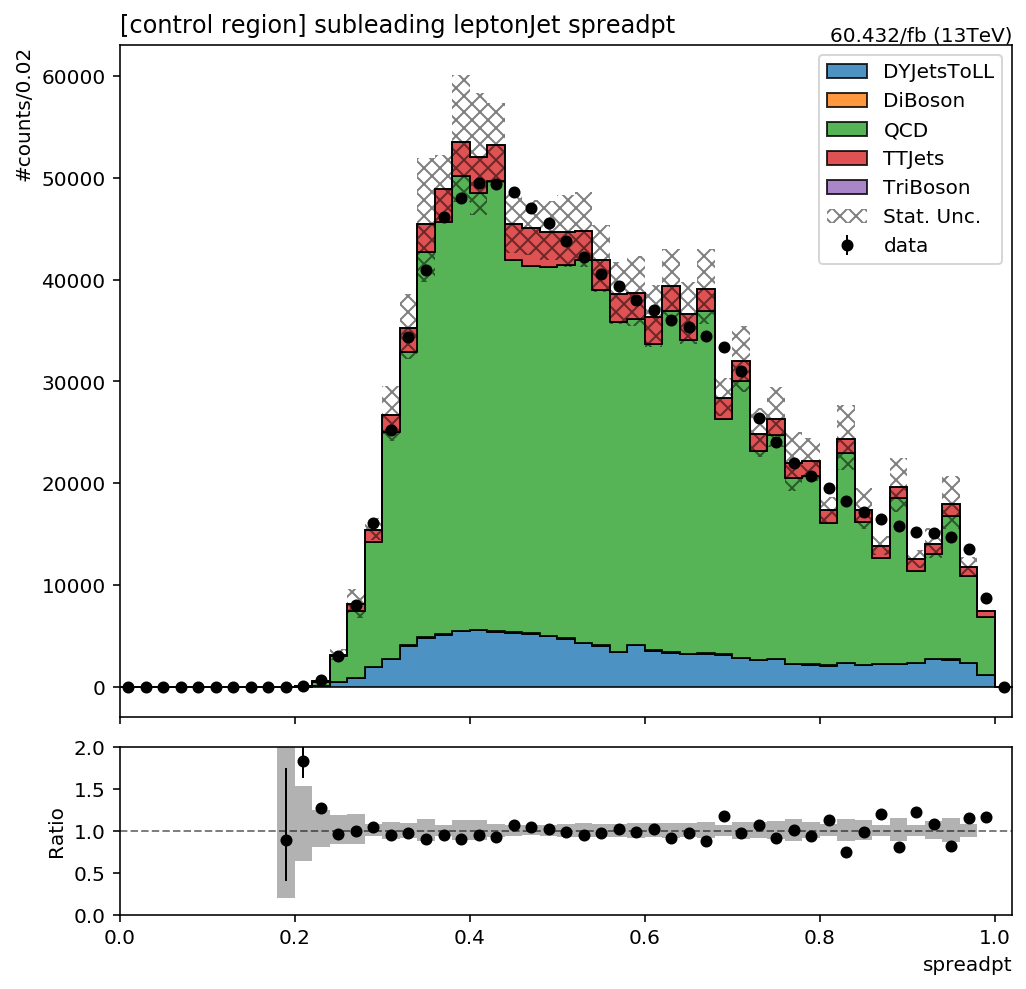

In [22]:
fig, (ax, rax) = plt.subplots(2, 1, figsize=(8,8), gridspec_kw={"height_ratios": (4, 1)}, sharex=True)
fig.subplots_adjust(hspace=.07)

hist.plot1d(output['subl_spreadpt_cat'][notdata], overlay='cat', ax=ax,
           clear=False, stack=True, overflow='over',
           line_opts=None, fill_opts=fill_opts, error_opts=error_opts)
hist.plot1d(output['subl_spreadpt_cat']['data'], overlay='cat', ax=ax,
           overflow='over', clear=False,
           error_opts=data_err_opts)
ax.autoscale(axis='x', tight=True)

ax.set_xlabel(None)
leg=ax.legend()

hist.plotratio(output['subl_spreadpt_cat']['data'].sum('cat'), output['subl_spreadpt_cat'][notdata].sum('cat'),
              ax=rax, overflow='over', unc='num',
              error_opts=data_err_opts, denom_fill_opts={}, guide_opts={})
rax.set_ylabel('Ratio')
rax.set_ylim(0,2)

rax.set_xlabel(rax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")
ax.set_title('[control region] subleading leptonJet spreadpt', x=0.0, ha="left")
ax.text(1,1,'60.432/fb (13TeV)', ha='right', va='bottom', transform=ax.transAxes);

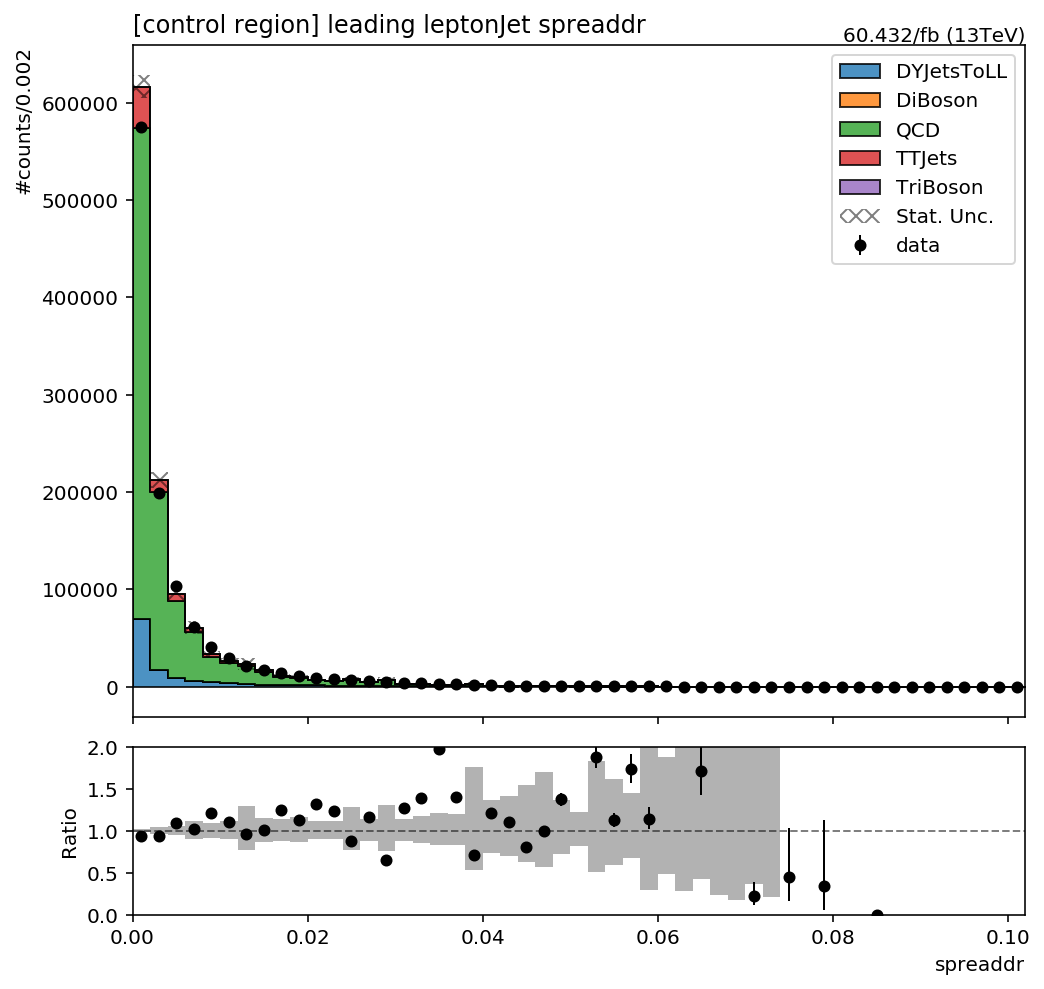

In [24]:
fig, (ax, rax) = plt.subplots(2, 1, figsize=(8,8), gridspec_kw={"height_ratios": (4, 1)}, sharex=True)
fig.subplots_adjust(hspace=.07)

hist.plot1d(output['lead_spreaddr_cat'][notdata], overlay='cat', ax=ax,
           clear=False, stack=True, overflow='over',
           line_opts=None, fill_opts=fill_opts, error_opts=error_opts)
hist.plot1d(output['lead_spreaddr_cat']['data'], overlay='cat', ax=ax,
           overflow='over', clear=False,
           error_opts=data_err_opts)
ax.autoscale(axis='x', tight=True)

ax.set_xlabel(None)
leg=ax.legend()

hist.plotratio(output['lead_spreaddr_cat']['data'].sum('cat'), output['lead_spreaddr_cat'][notdata].sum('cat'),
              ax=rax, overflow='over', unc='num',
              error_opts=data_err_opts, denom_fill_opts={}, guide_opts={})
rax.set_ylabel('Ratio')
rax.set_ylim(0,2)

rax.set_xlabel(rax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")
ax.set_title('[control region] leading leptonJet spreaddr', x=0.0, ha="left")
ax.text(1,1,'60.432/fb (13TeV)', ha='right', va='bottom', transform=ax.transAxes);

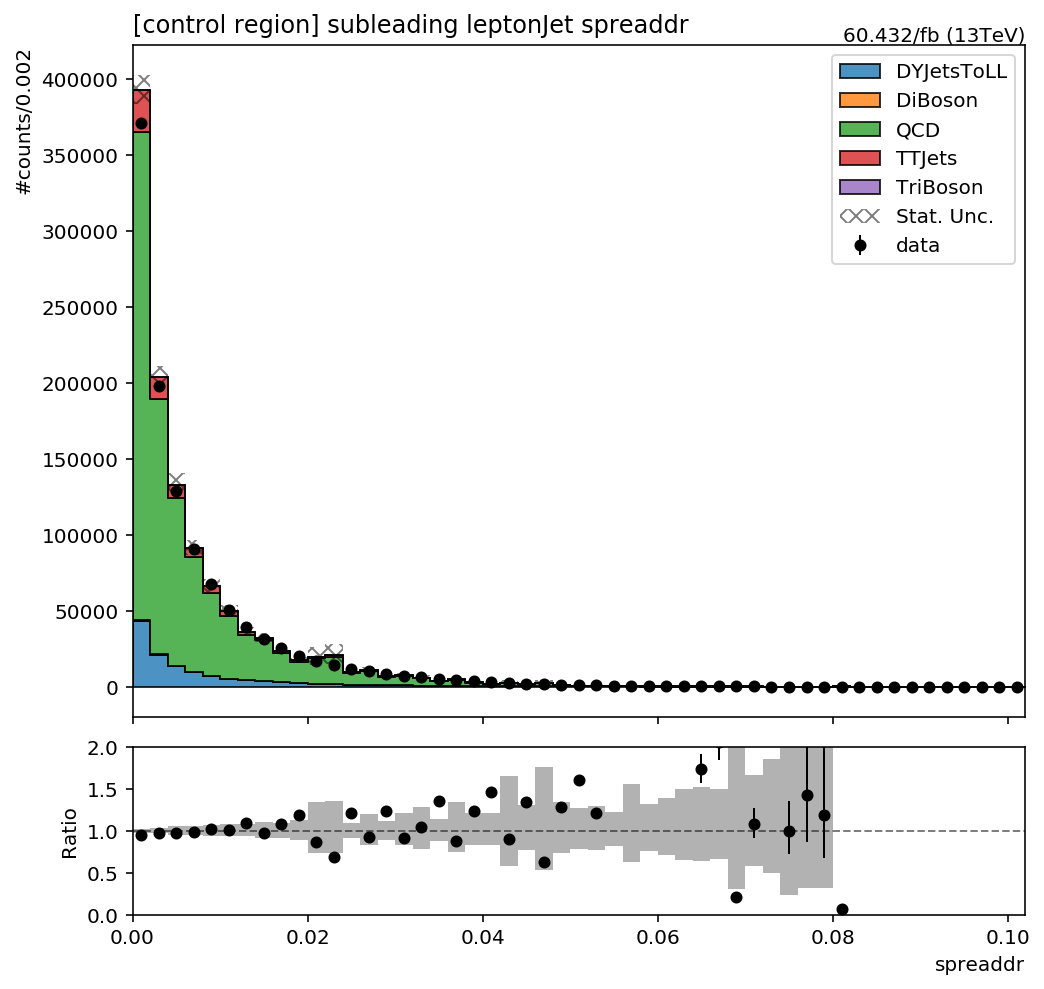

In [25]:
fig, (ax, rax) = plt.subplots(2, 1, figsize=(8,8), gridspec_kw={"height_ratios": (4, 1)}, sharex=True)
fig.subplots_adjust(hspace=.07)

hist.plot1d(output['subl_spreaddr_cat'][notdata], overlay='cat', ax=ax,
           clear=False, stack=True, overflow='over',
           line_opts=None, fill_opts=fill_opts, error_opts=error_opts)
hist.plot1d(output['subl_spreaddr_cat']['data'], overlay='cat', ax=ax,
           overflow='over', clear=False,
           error_opts=data_err_opts)
ax.autoscale(axis='x', tight=True)

ax.set_xlabel(None)
leg=ax.legend()

hist.plotratio(output['subl_spreaddr_cat']['data'].sum('cat'), output['subl_spreaddr_cat'][notdata].sum('cat'),
              ax=rax, overflow='over', unc='num',
              error_opts=data_err_opts, denom_fill_opts={}, guide_opts={})
rax.set_ylabel('Ratio')
rax.set_ylim(0,2)

rax.set_xlabel(rax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")
ax.set_title('[control region] subleading leptonJet spreaddr', x=0.0, ha="left")
ax.text(1,1,'60.432/fb (13TeV)', ha='right', va='bottom', transform=ax.transAxes);

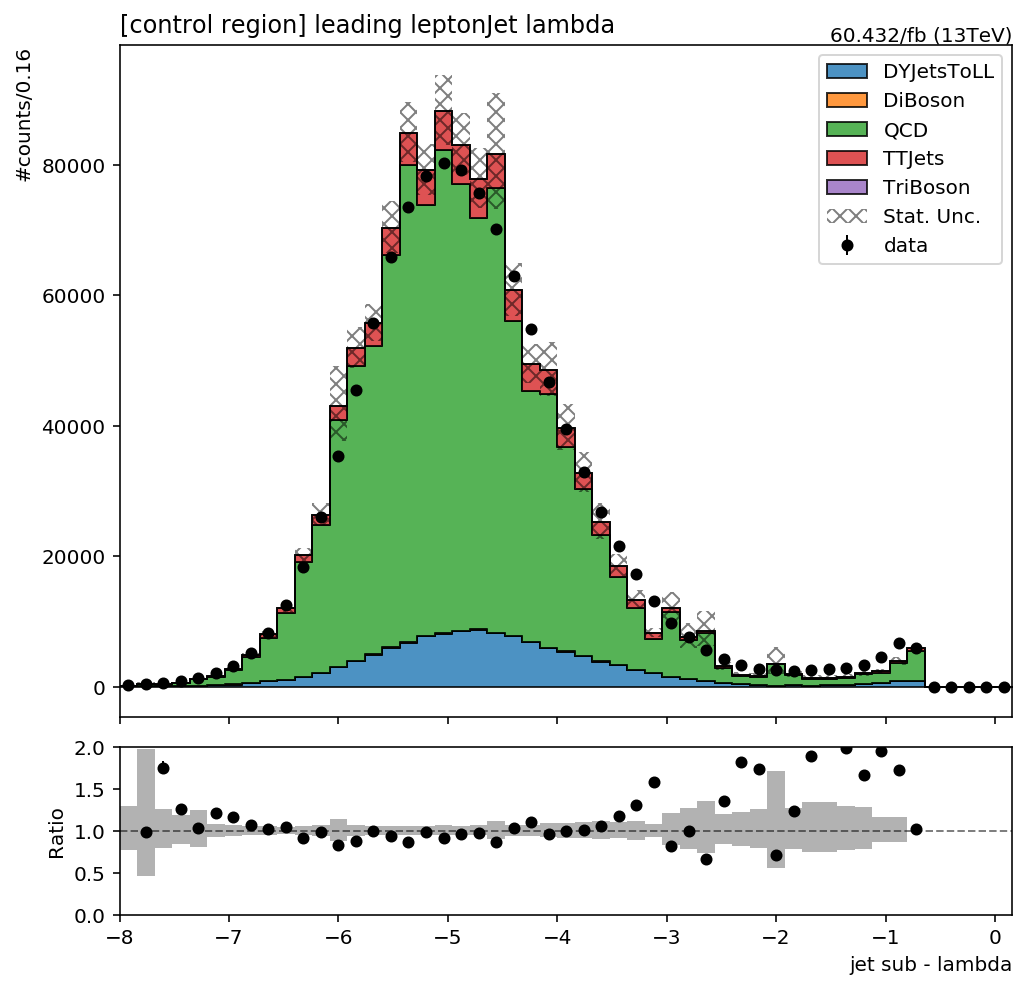

In [26]:
fig, (ax, rax) = plt.subplots(2, 1, figsize=(8,8), gridspec_kw={"height_ratios": (4, 1)}, sharex=True)
fig.subplots_adjust(hspace=.07)

hist.plot1d(output['lead_lamb_cat'][notdata], overlay='cat', ax=ax,
           clear=False, stack=True, overflow='over',
           line_opts=None, fill_opts=fill_opts, error_opts=error_opts)
hist.plot1d(output['lead_lamb_cat']['data'], overlay='cat', ax=ax,
           overflow='over', clear=False,
           error_opts=data_err_opts)
ax.autoscale(axis='x', tight=True)

ax.set_xlabel(None)
leg=ax.legend()

hist.plotratio(output['lead_lamb_cat']['data'].sum('cat'), output['lead_lamb_cat'][notdata].sum('cat'),
              ax=rax, overflow='over', unc='num',
              error_opts=data_err_opts, denom_fill_opts={}, guide_opts={})
rax.set_ylabel('Ratio')
rax.set_ylim(0,2)

rax.set_xlabel(rax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")
ax.set_title('[control region] leading leptonJet lambda', x=0.0, ha="left")
ax.text(1,1,'60.432/fb (13TeV)', ha='right', va='bottom', transform=ax.transAxes);

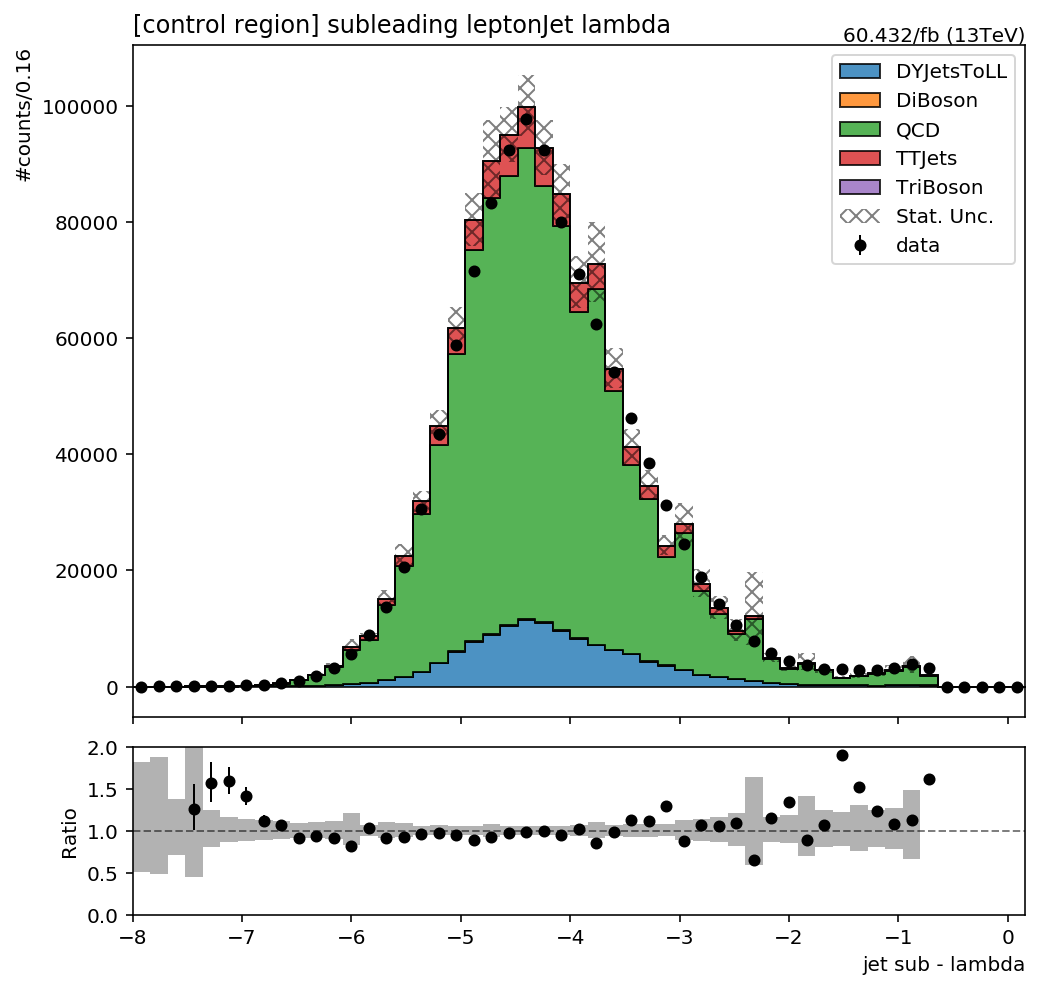

In [27]:
fig, (ax, rax) = plt.subplots(2, 1, figsize=(8,8), gridspec_kw={"height_ratios": (4, 1)}, sharex=True)
fig.subplots_adjust(hspace=.07)

hist.plot1d(output['subl_lamb_cat'][notdata], overlay='cat', ax=ax,
           clear=False, stack=True, overflow='over',
           line_opts=None, fill_opts=fill_opts, error_opts=error_opts)
hist.plot1d(output['subl_lamb_cat']['data'], overlay='cat', ax=ax,
           overflow='over', clear=False,
           error_opts=data_err_opts)
ax.autoscale(axis='x', tight=True)

ax.set_xlabel(None)
leg=ax.legend()

hist.plotratio(output['subl_lamb_cat']['data'].sum('cat'), output['subl_lamb_cat'][notdata].sum('cat'),
              ax=rax, overflow='over', unc='num',
              error_opts=data_err_opts, denom_fill_opts={}, guide_opts={})
rax.set_ylabel('Ratio')
rax.set_ylim(0,2)

rax.set_xlabel(rax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")
ax.set_title('[control region] subleading leptonJet lambda', x=0.0, ha="left")
ax.text(1,1,'60.432/fb (13TeV)', ha='right', va='bottom', transform=ax.transAxes);

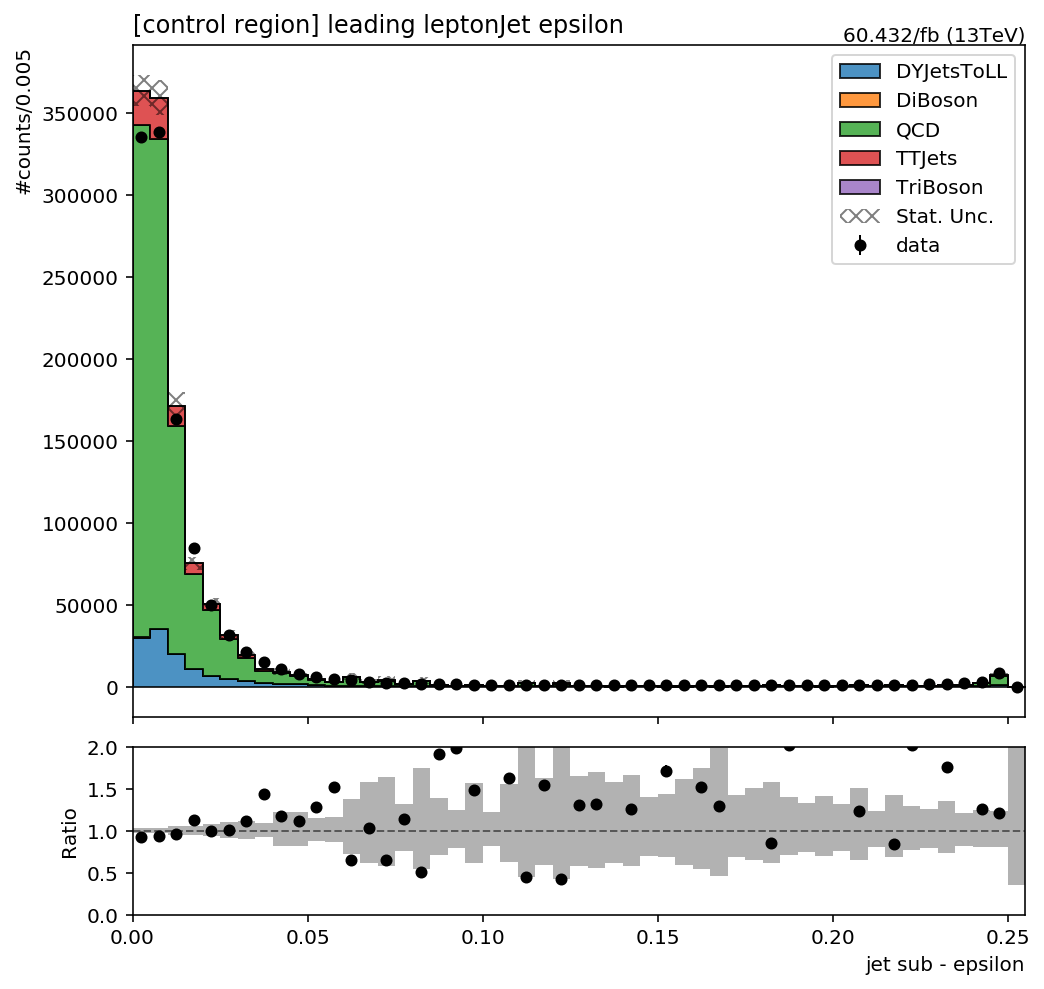

In [28]:
fig, (ax, rax) = plt.subplots(2, 1, figsize=(8,8), gridspec_kw={"height_ratios": (4, 1)}, sharex=True)
fig.subplots_adjust(hspace=.07)

hist.plot1d(output['lead_epsi_cat'][notdata], overlay='cat', ax=ax,
           clear=False, stack=True, overflow='over',
           line_opts=None, fill_opts=fill_opts, error_opts=error_opts)
hist.plot1d(output['lead_epsi_cat']['data'], overlay='cat', ax=ax,
           overflow='over', clear=False,
           error_opts=data_err_opts)
ax.autoscale(axis='x', tight=True)

ax.set_xlabel(None)
leg=ax.legend()

hist.plotratio(output['lead_epsi_cat']['data'].sum('cat'), output['lead_epsi_cat'][notdata].sum('cat'),
              ax=rax, overflow='over', unc='num',
              error_opts=data_err_opts, denom_fill_opts={}, guide_opts={})
rax.set_ylabel('Ratio')
rax.set_ylim(0,2)

rax.set_xlabel(rax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")
ax.set_title('[control region] leading leptonJet epsilon', x=0.0, ha="left")
ax.text(1,1,'60.432/fb (13TeV)', ha='right', va='bottom', transform=ax.transAxes);

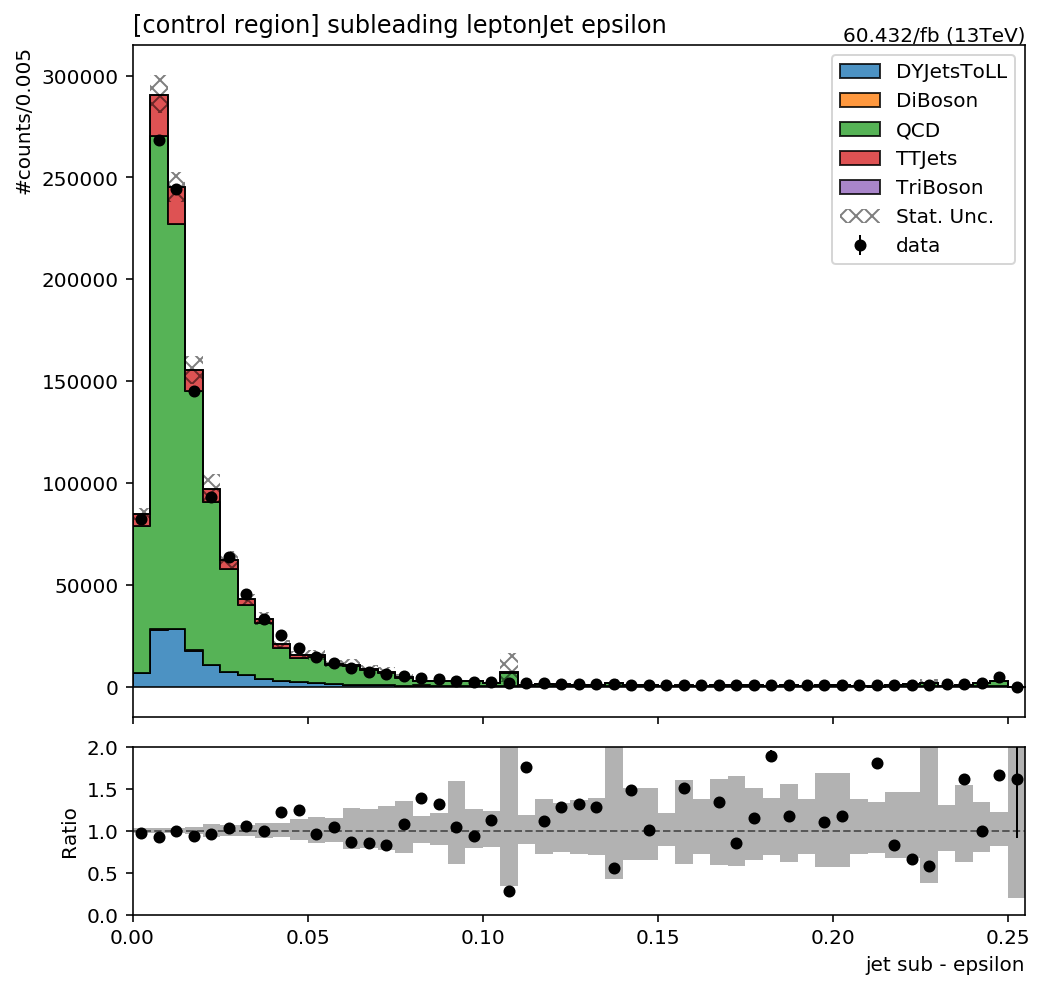

In [29]:
fig, (ax, rax) = plt.subplots(2, 1, figsize=(8,8), gridspec_kw={"height_ratios": (4, 1)}, sharex=True)
fig.subplots_adjust(hspace=.07)

hist.plot1d(output['subl_epsi_cat'][notdata], overlay='cat', ax=ax,
           clear=False, stack=True, overflow='over',
           line_opts=None, fill_opts=fill_opts, error_opts=error_opts)
hist.plot1d(output['subl_epsi_cat']['data'], overlay='cat', ax=ax,
           overflow='over', clear=False,
           error_opts=data_err_opts)
ax.autoscale(axis='x', tight=True)

ax.set_xlabel(None)
leg=ax.legend()

hist.plotratio(output['subl_epsi_cat']['data'].sum('cat'), output['subl_epsi_cat'][notdata].sum('cat'),
              ax=rax, overflow='over', unc='num',
              error_opts=data_err_opts, denom_fill_opts={}, guide_opts={})
rax.set_ylabel('Ratio')
rax.set_ylim(0,2)

rax.set_xlabel(rax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")
ax.set_title('[control region] subleading leptonJet epsilon', x=0.0, ha="left")
ax.text(1,1,'60.432/fb (13TeV)', ha='right', va='bottom', transform=ax.transAxes);

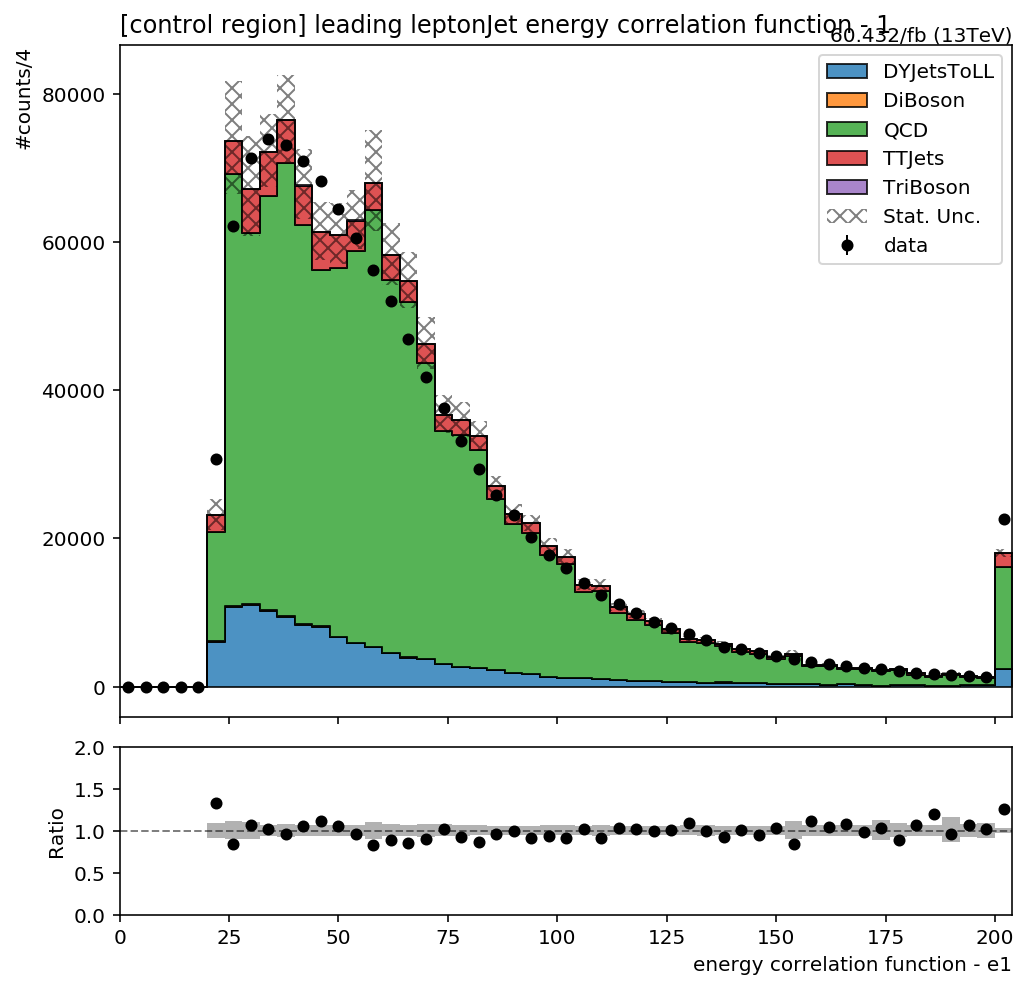

In [30]:
fig, (ax, rax) = plt.subplots(2, 1, figsize=(8,8), gridspec_kw={"height_ratios": (4, 1)}, sharex=True)
fig.subplots_adjust(hspace=.07)

hist.plot1d(output['lead_ecfe1_cat'][notdata], overlay='cat', ax=ax,
           clear=False, stack=True, overflow='over',
           line_opts=None, fill_opts=fill_opts, error_opts=error_opts)
hist.plot1d(output['lead_ecfe1_cat']['data'], overlay='cat', ax=ax,
           overflow='over', clear=False,
           error_opts=data_err_opts)
ax.autoscale(axis='x', tight=True)

ax.set_xlabel(None)
leg=ax.legend()

hist.plotratio(output['lead_ecfe1_cat']['data'].sum('cat'), output['lead_ecfe1_cat'][notdata].sum('cat'),
              ax=rax, overflow='over', unc='num',
              error_opts=data_err_opts, denom_fill_opts={}, guide_opts={})
rax.set_ylabel('Ratio')
rax.set_ylim(0,2)

rax.set_xlabel(rax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")
ax.set_title('[control region] leading leptonJet energy correlation function - 1', x=0.0, ha="left")
ax.text(1,1,'60.432/fb (13TeV)', ha='right', va='bottom', transform=ax.transAxes);

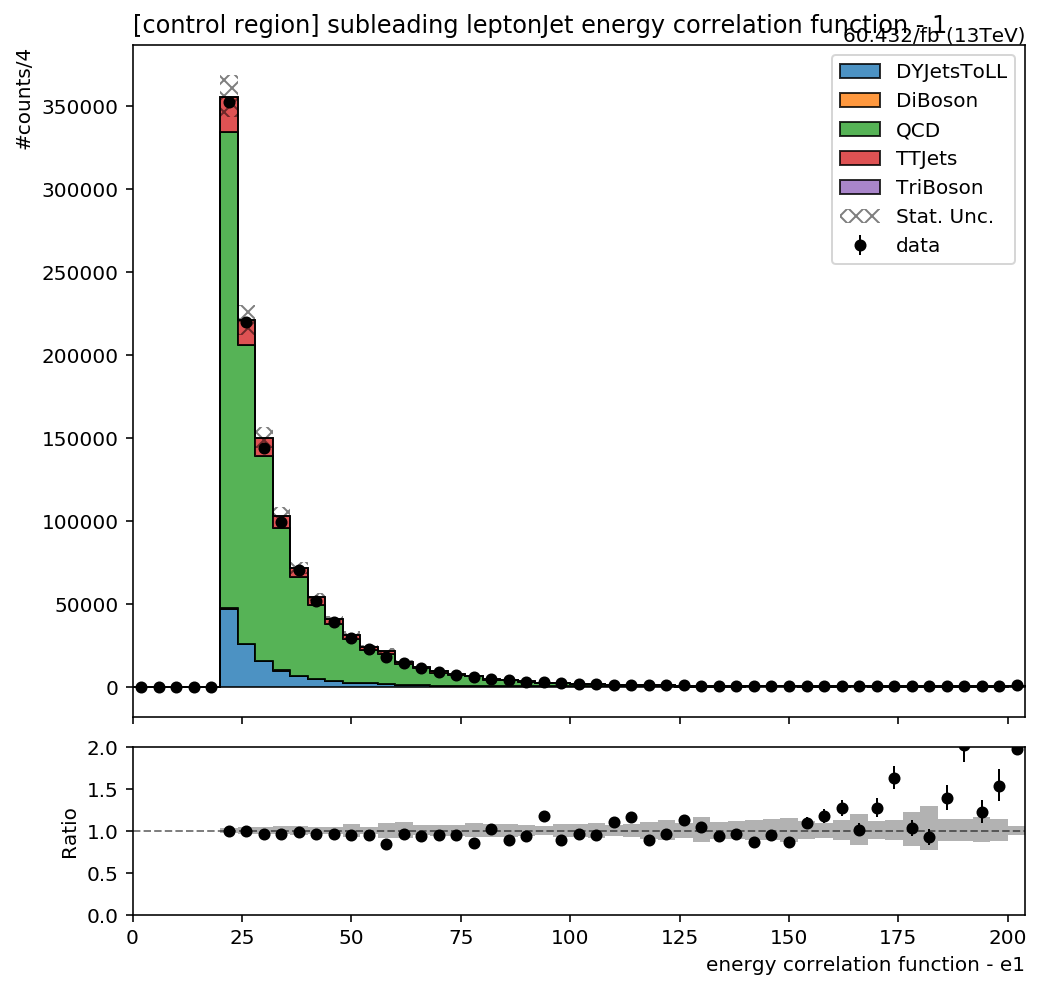

In [31]:
fig, (ax, rax) = plt.subplots(2, 1, figsize=(8,8), gridspec_kw={"height_ratios": (4, 1)}, sharex=True)
fig.subplots_adjust(hspace=.07)

hist.plot1d(output['subl_ecfe1_cat'][notdata], overlay='cat', ax=ax,
           clear=False, stack=True, overflow='over',
           line_opts=None, fill_opts=fill_opts, error_opts=error_opts)
hist.plot1d(output['subl_ecfe1_cat']['data'], overlay='cat', ax=ax,
           overflow='over', clear=False,
           error_opts=data_err_opts)
ax.autoscale(axis='x', tight=True)

ax.set_xlabel(None)
leg=ax.legend()

hist.plotratio(output['subl_ecfe1_cat']['data'].sum('cat'), output['subl_ecfe1_cat'][notdata].sum('cat'),
              ax=rax, overflow='over', unc='num',
              error_opts=data_err_opts, denom_fill_opts={}, guide_opts={})
rax.set_ylabel('Ratio')
rax.set_ylim(0,2)

rax.set_xlabel(rax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")
ax.set_title('[control region] subleading leptonJet energy correlation function - 1', x=0.0, ha="left")
ax.text(1,1,'60.432/fb (13TeV)', ha='right', va='bottom', transform=ax.transAxes);

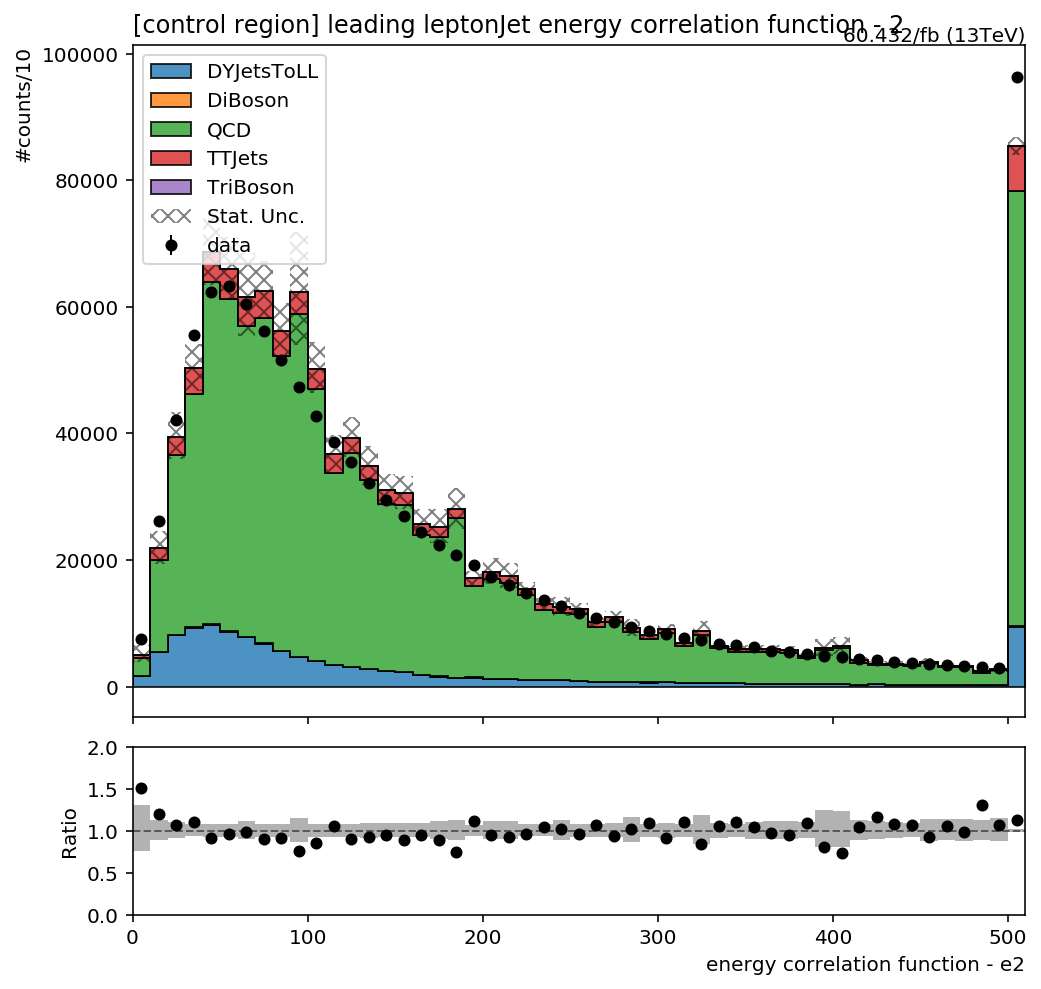

In [32]:
fig, (ax, rax) = plt.subplots(2, 1, figsize=(8,8), gridspec_kw={"height_ratios": (4, 1)}, sharex=True)
fig.subplots_adjust(hspace=.07)

hist.plot1d(output['lead_ecfe2_cat'][notdata], overlay='cat', ax=ax,
           clear=False, stack=True, overflow='over',
           line_opts=None, fill_opts=fill_opts, error_opts=error_opts)
hist.plot1d(output['lead_ecfe2_cat']['data'], overlay='cat', ax=ax,
           overflow='over', clear=False,
           error_opts=data_err_opts)
ax.autoscale(axis='x', tight=True)

ax.set_xlabel(None)
leg=ax.legend()

hist.plotratio(output['lead_ecfe2_cat']['data'].sum('cat'), output['lead_ecfe2_cat'][notdata].sum('cat'),
              ax=rax, overflow='over', unc='num',
              error_opts=data_err_opts, denom_fill_opts={}, guide_opts={})
rax.set_ylabel('Ratio')
rax.set_ylim(0,2)

rax.set_xlabel(rax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")
ax.set_title('[control region] leading leptonJet energy correlation function - 2', x=0.0, ha="left")
ax.text(1,1,'60.432/fb (13TeV)', ha='right', va='bottom', transform=ax.transAxes);

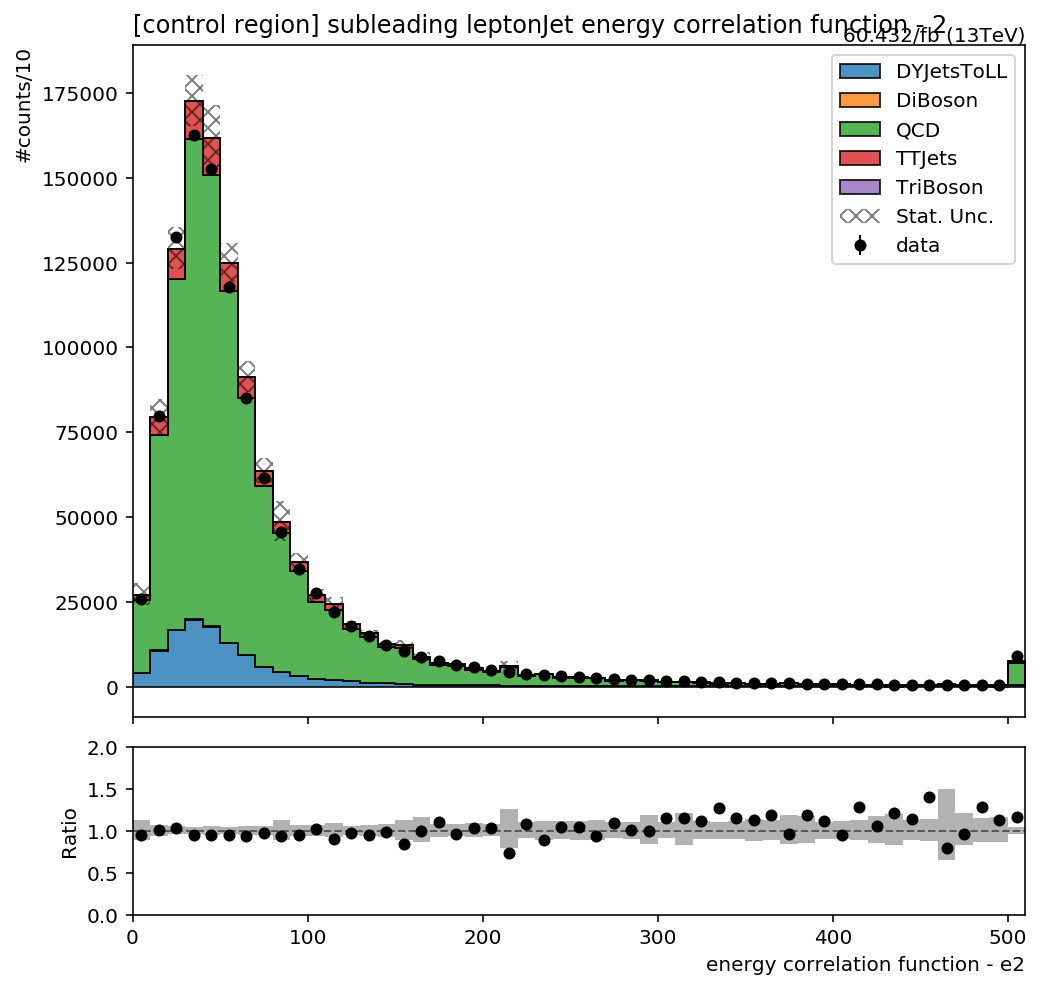

In [33]:
fig, (ax, rax) = plt.subplots(2, 1, figsize=(8,8), gridspec_kw={"height_ratios": (4, 1)}, sharex=True)
fig.subplots_adjust(hspace=.07)

hist.plot1d(output['subl_ecfe2_cat'][notdata], overlay='cat', ax=ax,
           clear=False, stack=True, overflow='over',
           line_opts=None, fill_opts=fill_opts, error_opts=error_opts)
hist.plot1d(output['subl_ecfe2_cat']['data'], overlay='cat', ax=ax,
           overflow='over', clear=False,
           error_opts=data_err_opts)
ax.autoscale(axis='x', tight=True)

ax.set_xlabel(None)
leg=ax.legend()

hist.plotratio(output['subl_ecfe2_cat']['data'].sum('cat'), output['subl_ecfe2_cat'][notdata].sum('cat'),
              ax=rax, overflow='over', unc='num',
              error_opts=data_err_opts, denom_fill_opts={}, guide_opts={})
rax.set_ylabel('Ratio')
rax.set_ylim(0,2)

rax.set_xlabel(rax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")
ax.set_title('[control region] subleading leptonJet energy correlation function - 2', x=0.0, ha="left")
ax.text(1,1,'60.432/fb (13TeV)', ha='right', va='bottom', transform=ax.transAxes);

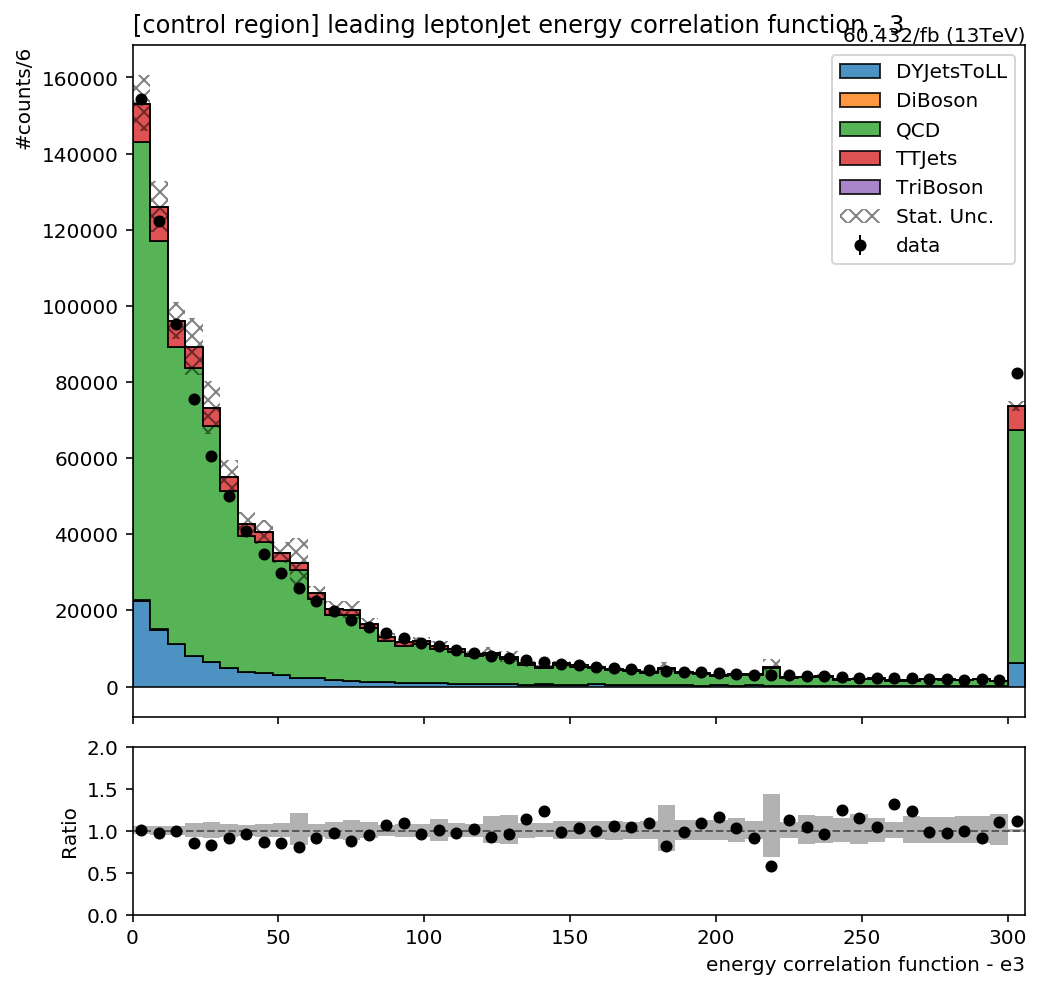

In [34]:
fig, (ax, rax) = plt.subplots(2, 1, figsize=(8,8), gridspec_kw={"height_ratios": (4, 1)}, sharex=True)
fig.subplots_adjust(hspace=.07)

hist.plot1d(output['lead_ecfe3_cat'][notdata], overlay='cat', ax=ax,
           clear=False, stack=True, overflow='over',
           line_opts=None, fill_opts=fill_opts, error_opts=error_opts)
hist.plot1d(output['lead_ecfe3_cat']['data'], overlay='cat', ax=ax,
           overflow='over', clear=False,
           error_opts=data_err_opts)
ax.autoscale(axis='x', tight=True)

ax.set_xlabel(None)
leg=ax.legend()

hist.plotratio(output['lead_ecfe3_cat']['data'].sum('cat'), output['lead_ecfe3_cat'][notdata].sum('cat'),
              ax=rax, overflow='over', unc='num',
              error_opts=data_err_opts, denom_fill_opts={}, guide_opts={})
rax.set_ylabel('Ratio')
rax.set_ylim(0,2)

rax.set_xlabel(rax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")
ax.set_title('[control region] leading leptonJet energy correlation function - 3', x=0.0, ha="left")
ax.text(1,1,'60.432/fb (13TeV)', ha='right', va='bottom', transform=ax.transAxes);

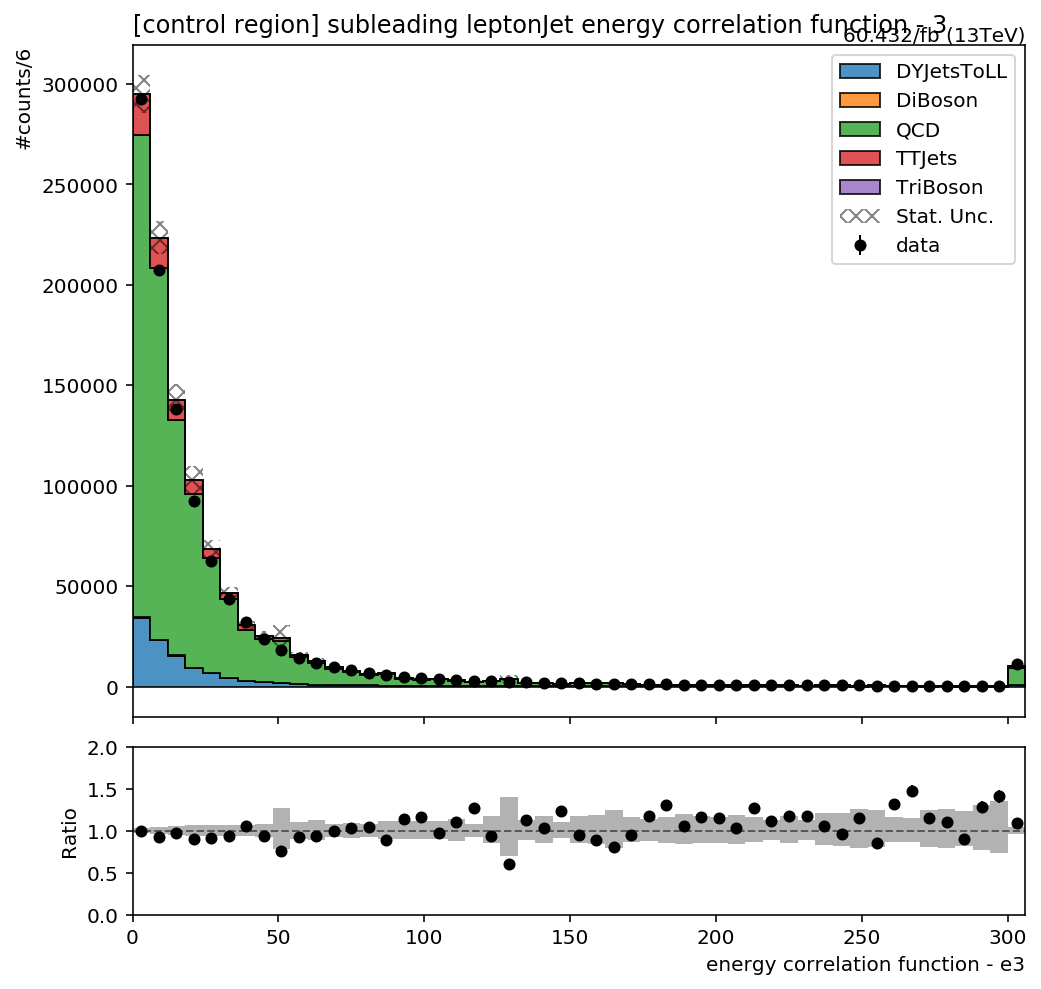

In [35]:
fig, (ax, rax) = plt.subplots(2, 1, figsize=(8,8), gridspec_kw={"height_ratios": (4, 1)}, sharex=True)
fig.subplots_adjust(hspace=.07)

hist.plot1d(output['subl_ecfe3_cat'][notdata], overlay='cat', ax=ax,
           clear=False, stack=True, overflow='over',
           line_opts=None, fill_opts=fill_opts, error_opts=error_opts)
hist.plot1d(output['subl_ecfe3_cat']['data'], overlay='cat', ax=ax,
           overflow='over', clear=False,
           error_opts=data_err_opts)
ax.autoscale(axis='x', tight=True)

ax.set_xlabel(None)
leg=ax.legend()

hist.plotratio(output['subl_ecfe3_cat']['data'].sum('cat'), output['subl_ecfe3_cat'][notdata].sum('cat'),
              ax=rax, overflow='over', unc='num',
              error_opts=data_err_opts, denom_fill_opts={}, guide_opts={})
rax.set_ylabel('Ratio')
rax.set_ylim(0,2)

rax.set_xlabel(rax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")
ax.set_title('[control region] subleading leptonJet energy correlation function - 3', x=0.0, ha="left")
ax.text(1,1,'60.432/fb (13TeV)', ha='right', va='bottom', transform=ax.transAxes);

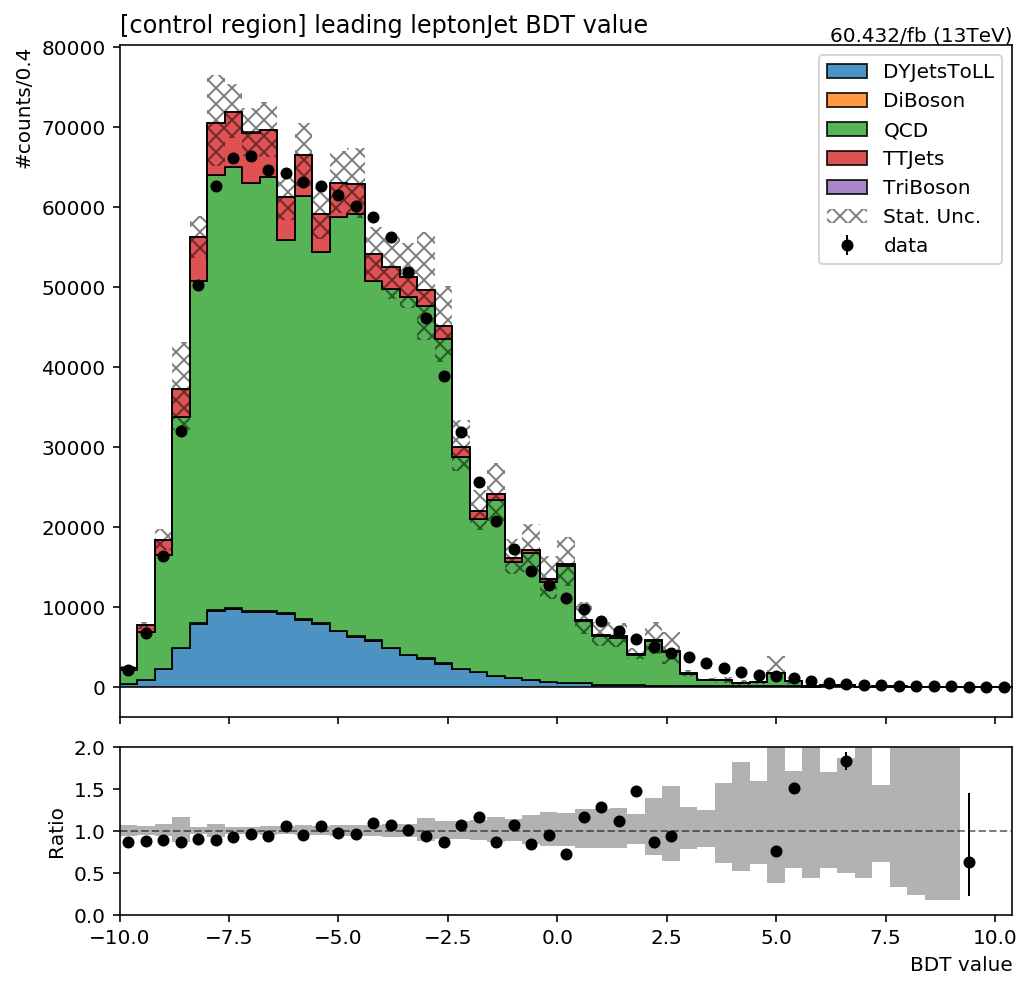

In [36]:
fig, (ax, rax) = plt.subplots(2, 1, figsize=(8,8), gridspec_kw={"height_ratios": (4, 1)}, sharex=True)
fig.subplots_adjust(hspace=.07)

hist.plot1d(output['lead_mva_cat'][notdata], overlay='cat', ax=ax,
           clear=False, stack=True, overflow='over',
           line_opts=None, fill_opts=fill_opts, error_opts=error_opts)
hist.plot1d(output['lead_mva_cat']['data'], overlay='cat', ax=ax,
           overflow='over', clear=False,
           error_opts=data_err_opts)
ax.autoscale(axis='x', tight=True)

ax.set_xlabel(None)
leg=ax.legend()

hist.plotratio(output['lead_mva_cat']['data'].sum('cat'), output['lead_mva_cat'][notdata].sum('cat'),
              ax=rax, overflow='over', unc='num',
              error_opts=data_err_opts, denom_fill_opts={}, guide_opts={})
rax.set_ylabel('Ratio')
rax.set_ylim(0,2)

rax.set_xlabel(rax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")
ax.set_title('[control region] leading leptonJet BDT value', x=0.0, ha="left")
ax.text(1,1,'60.432/fb (13TeV)', ha='right', va='bottom', transform=ax.transAxes);

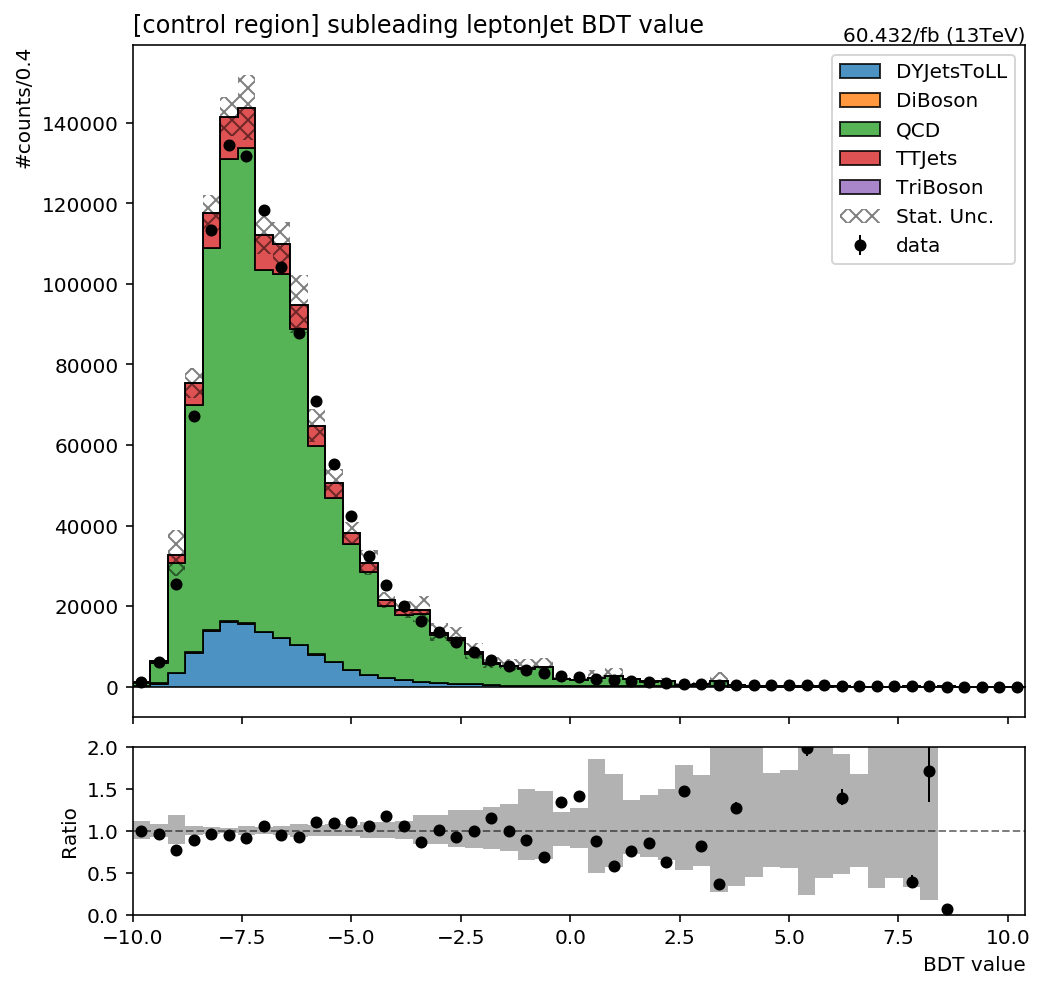

In [37]:
fig, (ax, rax) = plt.subplots(2, 1, figsize=(8,8), gridspec_kw={"height_ratios": (4, 1)}, sharex=True)
fig.subplots_adjust(hspace=.07)

hist.plot1d(output['subl_mva_cat'][notdata], overlay='cat', ax=ax,
           clear=False, stack=True, overflow='over',
           line_opts=None, fill_opts=fill_opts, error_opts=error_opts)
hist.plot1d(output['subl_mva_cat']['data'], overlay='cat', ax=ax,
           overflow='over', clear=False,
           error_opts=data_err_opts)
ax.autoscale(axis='x', tight=True)

ax.set_xlabel(None)
leg=ax.legend()

hist.plotratio(output['subl_mva_cat']['data'].sum('cat'), output['subl_mva_cat'][notdata].sum('cat'),
              ax=rax, overflow='over', unc='num',
              error_opts=data_err_opts, denom_fill_opts={}, guide_opts={})
rax.set_ylabel('Ratio')
rax.set_ylim(0,2)

rax.set_xlabel(rax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")
ax.set_title('[control region] subleading leptonJet BDT value', x=0.0, ha="left")
ax.text(1,1,'60.432/fb (13TeV)', ha='right', va='bottom', transform=ax.transAxes);